# Contents :
**Part 0 : Environment Setup**
 - <a href="#C1">Importation of libraries</a>
 - <a href="#C2">Definition of functions</a>
 - <a href="#C3">Dataset import</a>
 
**Part 1 : Dataset Cleaning**
 - <a href="#C4">Dataset aggregation</a>
 - <a href="#C5">Observations selection</a>
 - <a href="#C6">Variables selection</a>
 - <a href="#C7">Cleaning</a>
  
**Part 2 : Feature Enginnering**
 - <a href="#C8">New variables creation</a>
 - <a href="#C9">Combination of modalities</a>
 - <a href="#C10">Transformation of dummy variables</a>

**Part 3 : Exploratory Analysis**
 - <a href="#C11">Distribution of variables</a>
 - <a href="#C12">Correlation between variables</a>
 - <a href="#C13">Variables selection</a>

# Part 0 : Environment Setup

# <a name="C1">Importation of libraries</a>

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import missingno as msno
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import statsmodels.api as sm
import datetime as dt

import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
sns.set()

import scipy.stats as st
from scipy.cluster.hierarchy import dendrogram

from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

C:\Users\najwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\najwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# Displaying versions of libraries
print("pandas version : " + pd.__version__)
print("numpy version : " + np.__version__)
print("matplotlib version : " + mp.__version__)
print("seaborn version : " + sns.__version__)

pandas version : 1.4.2
numpy version : 1.21.5
matplotlib version : 3.5.1
seaborn version : 0.11.2


# <a name="C2">Definition of functions</a>

In [3]:
def analyse_quant(data, list_col):
    '''Function that analyses quantitative columns'''
    
    data_temp = pd.DataFrame(list_col, columns = ['Variable'])
    for i in range(len(list_col)):
        data_temp.loc[i,'Type'] = data[list_col[i]].dtype
        data_temp.loc[i,'NaN'] = data[list_col[i]].isna().sum()
        data_temp.loc[i,'NaN%'] = data[list_col[i]].isna().mean()
        data_temp.loc[i,'Min']=data[list_col[i]].min()
        data_temp.loc[i,'Max']=data[list_col[i]].max()
        data_temp.loc[i,'Moy']=data[list_col[i]].mean()
        data_temp.loc[i,'Med']=data[list_col[i]].median()
    data_temp = data_temp.sort_values(by='NaN')
    data_temp.reset_index(inplace = True,drop=True)
    
    return data_temp

In [4]:
def analyse_data(data):
    '''Function that analyses the dataset - size and NaNs'''
        
    print("Dataset shape : ", data.shape)
    print("% NaNs : ", data.isna().mean().mean())

In [5]:
def display_scree_plot(pca):
    '''Function specific to PCA'''
    
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rank of the axis of inertia")
    plt.ylabel("percentage of inertia")
    plt.title("Equats of eigenvalues")
    plt.show(block=False)

In [6]:
def plot_dendrogram(Z, names):
    '''Function specific to PCA'''
    
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

In [7]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Function specific to PCA'''
    
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialising figure       
            fig = plt.figure(figsize=(7,6))
        
            # Displaying points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Displaying labels of points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Determining graph limits
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Displaying horizontal et vertical lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Dispalying axix names, percentage of inertia
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of individuals (on F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [8]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    '''Function specific to PCA'''
    
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # Initialising figure  
            fig, ax = plt.subplots(figsize=(7,6))

            # Determining graph limits
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Displaying arrows
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (check doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Displaying names of variables
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # Dispalying the circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Determining graph limits
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Displaying horizontal et vertical lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Dispalying axix names, percentage of inertia
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlations circle (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

# <a name="C3">Dataset Import</a>

In [9]:
# Importing the 2 files
data_2015_or = pd.read_csv('2015-building-energy-benchmarking.csv')
data_2016_or = pd.read_csv('2016-building-energy-benchmarking.csv')

# Part 1 : Dataset Cleaning

In [10]:
# Copying the files
data_2015 = data_2015_or.copy() 
data_2016 = data_2016_or.copy() 

# <a name="C4">Dataset aggregation</a>

### Dataset aggregation

In [11]:
# Displaying first 2 rows
data_2015.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081


In [12]:
# Displaying first 2 rows
data_2016.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86


In [13]:
# Displaying size
print("Le fichier 2015 : ")
print(analyse_data(data_2015),"\n")
print("Le fichier 2016 : ")
print(analyse_data(data_2016))

Le fichier 2015 : 
Dataset shape :  (3340, 47)
% NaNs :  0.16888775640208942
None 

Le fichier 2016 : 
Dataset shape :  (3376, 46)
% NaNs :  0.12847723057902327
None


In [14]:
# Displaying columns
print("Les colonnes du fichier 2015 sont : ",data_2015.columns.tolist(),"\n")
print("Les colonnes du fichier 2016 sont : ",data_2016.columns.tolist())

Les colonnes du fichier 2015 sont :  ['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'TaxParcelIdentificationNumber', 'Location', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'DefaultData', 'Comment', 'ComplianceStatus', 'Outlier', '2010 Census Tracts', 'Sea

In [15]:
# Renaming few columns for convenience
data_2015 = data_2015.rename(columns = {'Seattle Police Department Micro Community Policing Plan Areas':'Policing Plan Areas'})

<AxesSubplot:>

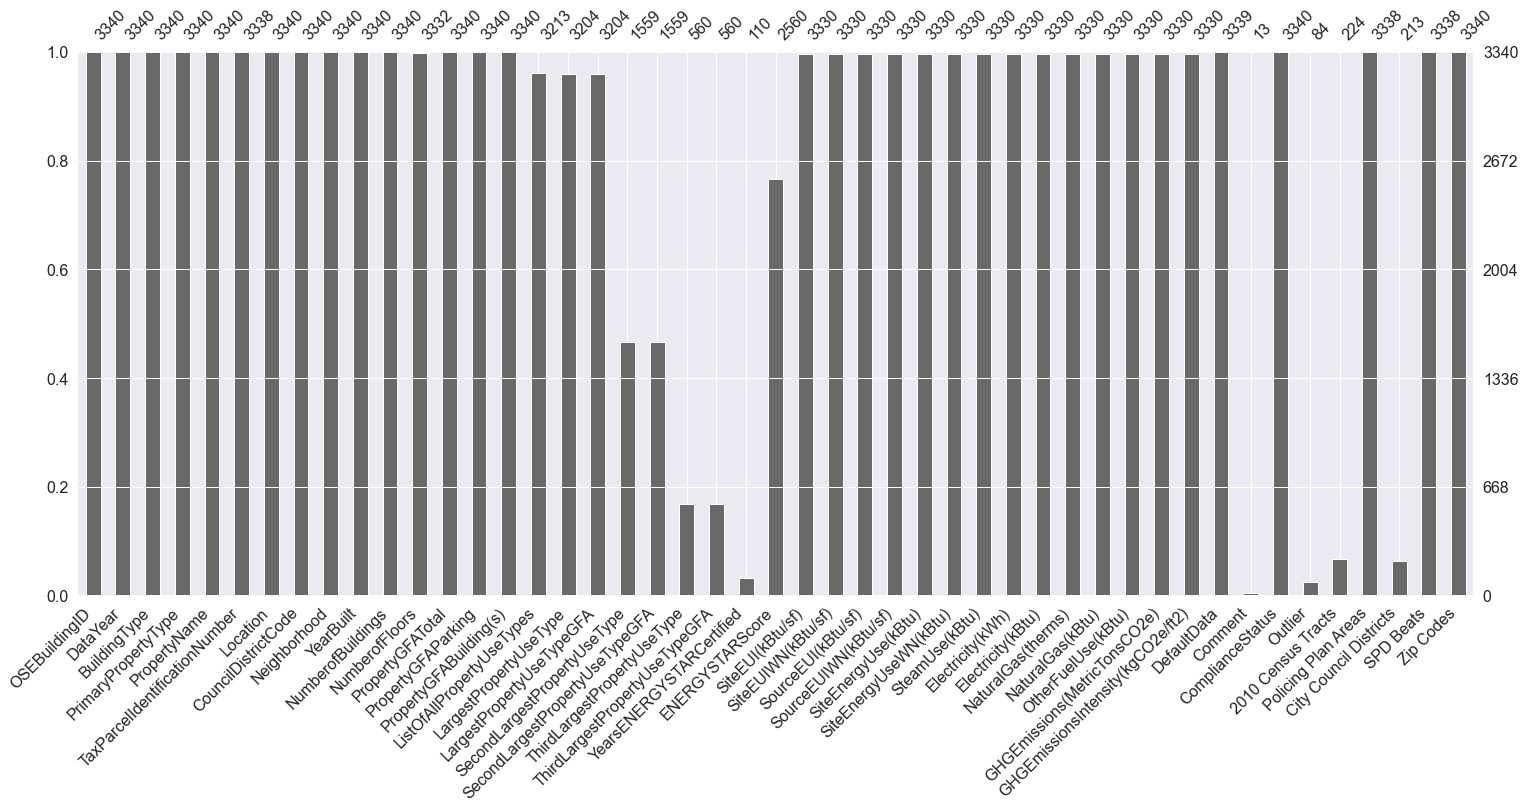

In [16]:
# Displaying NaNs for 2015
msno.bar(data_2015)

<AxesSubplot:>

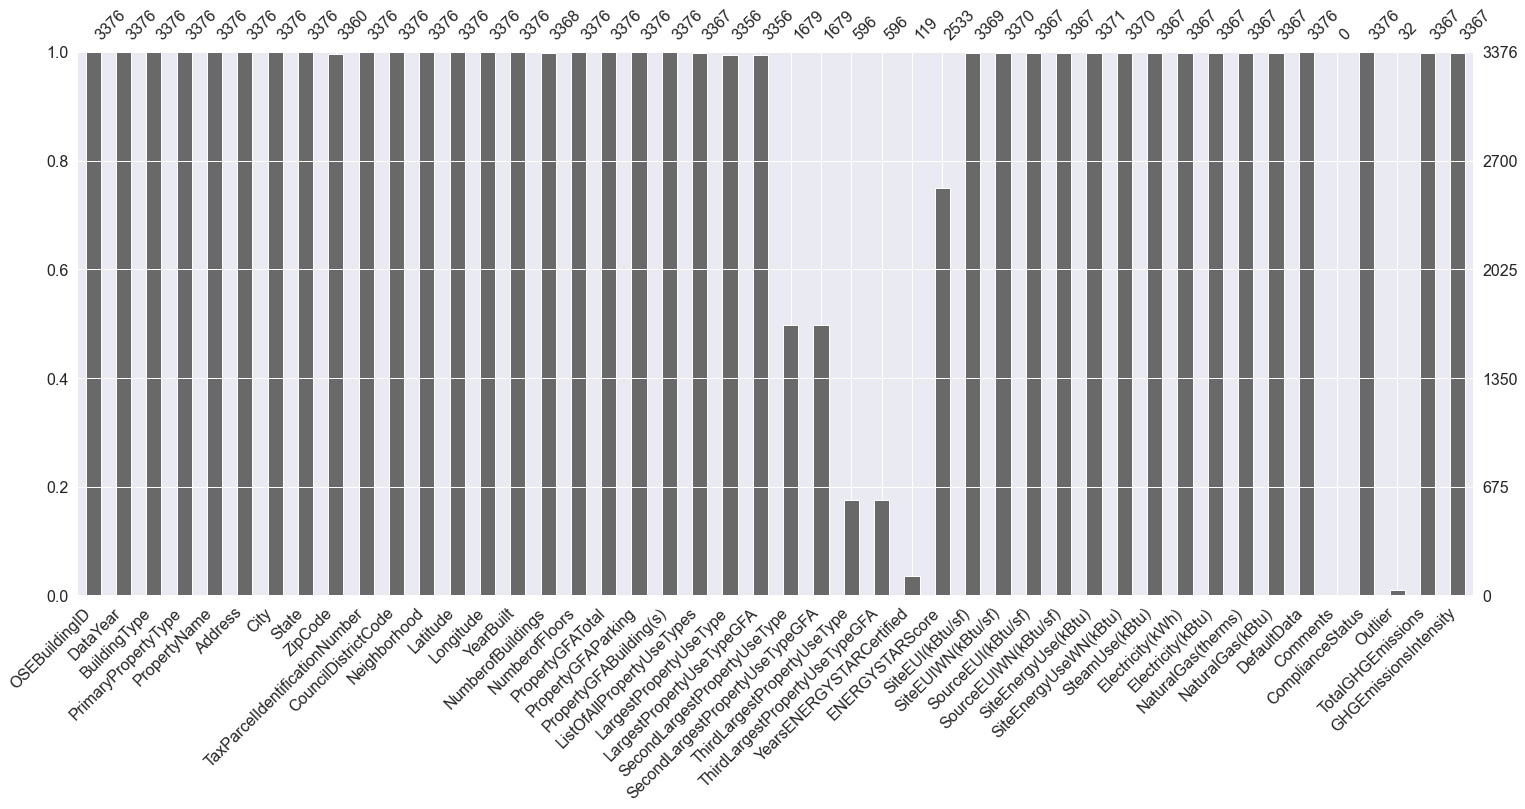

In [17]:
# Displaying NaNs for 2016
msno.bar(data_2016)

### Homogenisation of variable names

In [18]:
# Searching different columns between the 2 dataframes - listing columns in data2015 but missing from data2016
col_2015 = data_2015.columns.difference(data_2016.columns)
col_2015

Index(['2010 Census Tracts', 'City Council Districts', 'Comment',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'Location', 'OtherFuelUse(kBtu)', 'Policing Plan Areas', 'SPD Beats',
       'Zip Codes'],
      dtype='object')

In [19]:
# Searching different columns between the 2 dataframes - listing columns in data2016 but missing from data2015
col_2016 = data_2016.columns.difference(data_2015.columns)
col_2016

Index(['Address', 'City', 'Comments', 'GHGEmissionsIntensity', 'Latitude',
       'Longitude', 'State', 'TotalGHGEmissions', 'ZipCode'],
      dtype='object')

In [20]:
# Visualising in 2015 that are different
data_2015[col_2015].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   2010 Census Tracts                 224 non-null    float64
 1   City Council Districts             213 non-null    float64
 2   Comment                            13 non-null     object 
 3   GHGEmissions(MetricTonsCO2e)       3330 non-null   float64
 4   GHGEmissionsIntensity(kgCO2e/ft2)  3330 non-null   float64
 5   Location                           3340 non-null   object 
 6   OtherFuelUse(kBtu)                 3330 non-null   float64
 7   Policing Plan Areas                3338 non-null   float64
 8   SPD Beats                          3338 non-null   float64
 9   Zip Codes                          3340 non-null   int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 261.1+ KB


In [21]:
# Visualising in 2016 that are different
data_2016[col_2016].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Address                3376 non-null   object 
 1   City                   3376 non-null   object 
 2   Comments               0 non-null      float64
 3   GHGEmissionsIntensity  3367 non-null   float64
 4   Latitude               3376 non-null   float64
 5   Longitude              3376 non-null   float64
 6   State                  3376 non-null   object 
 7   TotalGHGEmissions      3367 non-null   float64
 8   ZipCode                3360 non-null   float64
dtypes: float64(6), object(3)
memory usage: 237.5+ KB


In [22]:
# Deleting column Comments of data2016 that is empty
data_2016.drop(['Comments'], axis=1, inplace=True)

In [23]:
# Analysing identical columns linked to CO2 emissions in data2015
data_2015[['GHGEmissionsIntensity(kgCO2e/ft2)','GHGEmissions(MetricTonsCO2e)']].describe()

,GHGEmissionsIntensity(kgCO2e/ft2),GHGEmissions(MetricTonsCO2e)
count,3330.000000,3330.000000
mean,0.985339,110.094102
std,1.637172,409.450179
min,0.000000,0.000000
25%,0.080000,9.265000
50%,0.460000,32.740000
75%,1.180000,88.642500
max,31.380000,11824.890000


In [24]:
# and the ones in data2016
data_2016[['GHGEmissionsIntensity','TotalGHGEmissions']].describe()

,GHGEmissionsIntensity,TotalGHGEmissions
count,3367.000000,3367.000000
mean,1.175916,119.723971
std,1.821452,538.832227
min,-0.020000,-0.800000
25%,0.210000,9.495000
50%,0.610000,33.920000
75%,1.370000,93.940000
max,34.090000,16870.980000


In [25]:
# The columns have similar order of magnitude and provide similar information.
data_2015['TotalGHGEmissions'] = data_2015['GHGEmissions(MetricTonsCO2e)']
data_2015['GHGEmissionsIntensity'] = data_2015['GHGEmissionsIntensity(kgCO2e/ft2)']
data_2015.drop(['GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)'], axis=1, inplace=True)

In [26]:
# Analysing column Location
data_2015['Location'].head(5)

0    {'latitude': '47.61219025', 'longitude': '-122...
1    {'latitude': '47.61310583', 'longitude': '-122...
2    {'latitude': '47.61334897', 'longitude': '-122...
3    {'latitude': '47.61421585', 'longitude': '-122...
4    {'latitude': '47.6137544', 'longitude': '-122....
Name: Location, dtype: object

In [27]:
# Analysing column Zip in data2015
data_2015['Zip Codes'].head(5)

0    18081
1    18081
2    18081
3    18081
4    19576
Name: Zip Codes, dtype: int64

In [28]:
# Analysing column Zip in data2016
data_2016['ZipCode'].head(5)

0    98101.0
1    98101.0
2    98101.0
3    98101.0
4    98121.0
Name: ZipCode, dtype: float64

In [29]:
# Deleting column Zip in data2015, which does not correspond to zip codes.
data_2015.drop(['Zip Codes'], axis=1, inplace=True)

In [30]:
# Extracting data from column Location
data_2015['Location'] = data_2015['Location'].apply(lambda x:x.lower())
data_2015['Location'].str.split(',',expand=True)

,0,1,2,3,4,5
0,{'latitude': '47.61219025','longitude': '-122.33799744',"'human_address': '{""address"": ""405 olive way""","""city"": ""seattle""","""state"": ""wa""","""zip"": ""98101""}'}"
1,{'latitude': '47.61310583','longitude': '-122.33335756',"'human_address': '{""address"": ""724 pine st""","""city"": ""seattle""","""state"": ""wa""","""zip"": ""98101""}'}"
2,{'latitude': '47.61334897','longitude': '-122.33769944',"'human_address': '{""address"": ""1900 5th ave""","""city"": ""seattle""","""state"": ""wa""","""zip"": ""98101""}'}"
3,{'latitude': '47.61421585','longitude': '-122.33660889',"'human_address': '{""address"": ""620 stewart st""","""city"": ""seattle""","""state"": ""wa""","""zip"": ""98101""}'}"
4,{'latitude': '47.6137544','longitude': '-122.3409238',"'human_address': '{""address"": ""401 lenora st""","""city"": ""seattle""","""state"": ""wa""","""zip"": ""98121""}'}"
...,...,...,...,...,...,...
3335,{'latitude': '47.59950256','longitude': '-122.32034302',"'human_address': '{""address"": ""321 10th ave s""","""city"": ""seattle""","""state"": ""wa""","""zip"": ""98104""}'}"
3336,{'latitude': '47.65752471','longitude': '-122.3160159',"'human_address': '{""address"": ""4123 12th ave ne""","""city"": ""seattle""","""state"": ""wa""","""zip"": ""98105""}'}"
3337,{'latitude': '47.61649845','longitude': '-122.33770787',"'human_address': '{""address"": ""2030 8th ave""","""city"": ""seattle""","""state"": ""wa""","""zip"": ""98121""}'}"
3338,{'latitude': '47.68396954','longitude': '-122.2874088',"'human_address': '{""address"": ""3801 ne 77th st""","""city"": ""seattle""","""state"": ""wa""","""zip"": ""98115""}'}"


In [31]:
# Creating detailed columns for 2015 and filling equivalent columns in 2016
latitude = data_2015['Location'].str.split(',',expand=True)[0]
data_2015['Latitude'] = latitude.str.split("'",expand=True)[3]

longitude = data_2015['Location'].str.split(',',expand=True)[1]
data_2015['Longitude'] = longitude.str.split("'",expand=True)[3]

address = data_2015['Location'].str.split(',',expand=True)[2]
data_2015['Address'] = address.str.split('"',expand=True)[3]
data_2015['Address'].str.lower()

city = data_2015['Location'].str.split(',',expand=True)[3]
data_2015['City'] = city.str.split('"',expand=True)[3]

state = data_2015['Location'].str.split(',',expand=True)[4]
data_2015['State'] = state.str.split('"',expand=True)[3]

zipcode = data_2015['Location'].str.split(',',expand=True)[5]
data_2015['ZipCode'] = zipcode.str.split('"',expand=True)[3]

In [32]:
# Removing column Location in data2015
data_2015.drop(['Location'], axis=1, inplace=True)

In [33]:
# Joining the 2 files into one file
data = data_2015.append(data_2016, ignore_index=True)

C:\Users\najwa\AppData\Local\Temp\ipykernel_11852\2533766129.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data_2015.append(data_2016, ignore_index=True)


### Homogenisation of modalities

In [34]:
# Analysing modalities of Neighborhood
data['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'CENTRAL', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'SOUTHWEST', 'DELRIDGE', 'Central',
       'Ballard', 'North', 'Delridge', 'Northwest',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

In [35]:
# Homogenising in uppercase
data['Neighborhood'] = data['Neighborhood'].str.upper()

In [36]:
# Grouping neighborhoods ad indicated in website of Seattle Housing Authority
data['Neighborhood'] = np.where(data['Neighborhood']=='EAST', 'CENTRAL', data['Neighborhood'])
data['Neighborhood'] = np.where(data['Neighborhood']=='NORTH', 'NORTHEAST', data['Neighborhood'])
data['Neighborhood'] = np.where(data['Neighborhood']=='LAKE UNION', 'NORTHWEST', data['Neighborhood'])
data['Neighborhood'] = np.where(data['Neighborhood']=='GREATER DUWAMISH', 'SOUTHEAST', data['Neighborhood'])
data['Neighborhood'] = np.where(data['Neighborhood']=='BALLARD', 'NORTHWEST', data['Neighborhood'])
data['Neighborhood'] = np.where(data['Neighborhood']=='SOUTHWEST', 'WEST / DELRIDGE', data['Neighborhood'])
data['Neighborhood'] = np.where(data['Neighborhood']=='DELRIDGE', 'WEST / DELRIDGE', data['Neighborhood'])
data['Neighborhood'] = np.where(data['Neighborhood']=='DELRIDGE NEIGHBORHOODS', 'WEST / DELRIDGE', data['Neighborhood'])

In [37]:
# Verifying modalities of Neighborhood
data['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'CENTRAL',
       'MAGNOLIA / QUEEN ANNE', 'NORTHWEST', 'WEST / DELRIDGE'],
      dtype=object)

In [38]:
# Analysing modalities of ComplianceStatus
data['ComplianceStatus'].unique()

array(['Compliant', 'Not Compliant', 'Error - Correct Default Data',
       'Missing Data', 'Non-Compliant'], dtype=object)

In [39]:
# Homogenising modalities
data['ComplianceStatus'] = np.where(data['ComplianceStatus']=='Non-Compliant', 0, data['ComplianceStatus'])
data['ComplianceStatus'] = np.where(data['ComplianceStatus']=='Error - Correct Default Data', 0, data['ComplianceStatus'])
data['ComplianceStatus'] = np.where(data['ComplianceStatus']=='Missing Data', 0, data['ComplianceStatus'])
data['ComplianceStatus'] = np.where(data['ComplianceStatus']=='Compliant', 1, data['ComplianceStatus'])
data['ComplianceStatus'] = np.where(data['ComplianceStatus']=='Not Compliant', 0, data['ComplianceStatus'])

In [40]:
# Analysing modalities of DefaultData
data['DefaultData'].unique()

array(['No', 'Yes', nan, False, True], dtype=object)

In [41]:
# Homogenising modalities
data['DefaultData'] = np.where(data['DefaultData']==True, 1, data['DefaultData'])
data['DefaultData'] = np.where(data['DefaultData']==False, 0, data['DefaultData'])
data['DefaultData'] = np.where(data['DefaultData']=="Yes", 1, data['DefaultData'])
data['DefaultData'] = np.where(data['DefaultData']=="No", 0, data['DefaultData'])
data['DefaultData'] = np.where(data['DefaultData']=="nan", 0, data['DefaultData'])

In [42]:
# Displaying types
data.dtypes

OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                     float64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseType        object
SecondLargestPropertyUseTypeGFA    float64
ThirdLargestPropertyUseType         object
ThirdLargestPropertyUseTypeGFA     float64
YearsENERGYSTARCertified            object
ENERGYSTARScore                    float64
SiteEUI(kBt

In [43]:
# Changing type objet to float for DefaultData and ComplianceStatus
data['DefaultData'] = data['DefaultData'].astype(float, errors = 'raise')
data['ComplianceStatus'] = data['ComplianceStatus'].astype(float, errors = 'raise')

In [44]:
# Copying new file data, if needed
data_or = data.copy()

# <a name="C5">Observations Selection</a>

In [45]:
# Dispaying first rows of data
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,City Council Districts,SPD Beats,TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address,City,State,ZipCode
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.0,...,NaN,31.0,249.43,2.64,47.61219025,-122.33799744,405 olive way,seattle,wa,98101
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1.0,...,NaN,31.0,263.51,2.38,47.61310583,-122.33335756,724 pine st,seattle,wa,98101
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1.0,...,NaN,31.0,2061.48,1.92,47.61334897,-122.33769944,1900 5th ave,seattle,wa,98101
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,7,DOWNTOWN,1926,1.0,...,NaN,31.0,1936.34,31.38,47.61421585,-122.33660889,620 stewart st,seattle,wa,98101
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,7,DOWNTOWN,1980,1.0,...,NaN,31.0,507.70,4.02,47.6137544,-122.3409238,401 lenora st,seattle,wa,98121


In [46]:
# Searching duplicates - from keys - building ID, Longitude and Latitude.
data.duplicated(['OSEBuildingID','Longitude','Latitude']).sum()

0

In [47]:
# Searching duplicates - from keys - building ID, Addresse
data.duplicated(['OSEBuildingID','Address']).sum()

22

In [48]:
# Searching duplicates - from key - building ID
data.duplicated('OSEBuildingID').sum()

3284

In [49]:
# Deleting older (2015) duplicates
data['NB_NA']=data.isna().sum(axis=1)
data = data.sort_values(by=['NB_NA','DataYear'],ascending=[True,False])
data=data.drop_duplicates('OSEBuildingID',keep='first')
data = data.drop('NB_NA', axis=1)

In [50]:
# Dislaying size of new file
data.shape

(3432, 51)

In [51]:
# Searching modalities of City, as only interested in Seattle
data['City'].unique().tolist()

['seattle', 'Seattle']

In [52]:
# Deleting City as only city is Seattle
data.drop('City',axis=1,inplace=True)

In [53]:

data['BuildingType'].unique().tolist()

['NonResidential',
 'Multifamily MR (5-9)',
 'Nonresidential COS',
 'Multifamily HR (10+)',
 'Multifamily LR (1-4)',
 'SPS-District K-12',
 'Campus',
 'Nonresidential WA']

In [54]:
# Searching modalities of PrimaryPropertyType as only interested in non residential building.
data['BuildingType'].fillna("unknown", inplace=True)
CAT = data.BuildingType.unique().tolist()
for column in CAT:
    print('Building Type is : ',column)
    print(data[data['BuildingType'] == column].PrimaryPropertyType.unique().tolist(),"\n")

Building Type is :  NonResidential
['Other', 'Retail Store', 'Large Office', 'Mixed Use Property', 'Small- and Mid-Sized Office', 'Worship Facility', 'Hotel', 'Residence Hall/Dormitory', 'Supermarket/Grocery Store', 'Distribution Center\n', 'Medical Office', 'Non-Refrigerated Warehouse', 'Hospital', 'Senior Care Community', 'Self-Storage Facility\n', 'Refrigerated Warehouse', 'K-12 School', 'Restaurant\n', 'Supermarket / Grocery Store', 'College/University', 'Low-Rise Multifamily', 'Warehouse', 'Residence Hall', 'Distribution Center', 'Restaurant', 'Laboratory', 'University', 'Self-Storage Facility'] 

Building Type is :  Multifamily MR (5-9)
['Mid-Rise Multifamily', 'Mixed Use Property', 'Senior Care Community', 'Other', 'Residence Hall'] 

Building Type is :  Nonresidential COS
['Large Office', 'Small- and Mid-Sized Office', 'Non-Refrigerated Warehouse', 'Other', 'Distribution Center\n', 'Mixed Use Property', 'Medical Office', 'Warehouse', 'Office'] 

Building Type is :  Multifamily 

In [55]:
# Focusing on PrimaryPRopertyType instead of BuildingType to filter non residential
data.PrimaryPropertyType.unique().tolist()

['Other',
 'Retail Store',
 'Mid-Rise Multifamily',
 'Large Office',
 'High-Rise Multifamily',
 'Mixed Use Property',
 'Low-Rise Multifamily',
 'Small- and Mid-Sized Office',
 'Worship Facility',
 'Hotel',
 'Residence Hall/Dormitory',
 'Supermarket/Grocery Store',
 'Distribution Center\n',
 'Medical Office',
 'Non-Refrigerated Warehouse',
 'Hospital',
 'Senior Care Community',
 'Self-Storage Facility\n',
 'K-12 School',
 'Refrigerated Warehouse',
 'Restaurant\n',
 'Supermarket / Grocery Store',
 'College/University',
 'Warehouse',
 'Residence Hall',
 'Distribution Center',
 'Restaurant',
 'Laboratory',
 'University',
 'Office',
 'Self-Storage Facility']

In [56]:
# Homogenising PrimaryPRopertyType and deleting charactere \n at the end of some modalities
data['PrimaryPropertyType'] = data['PrimaryPropertyType'].str.replace('\n','')

In [57]:
# Looking at the nb of buildings per modality
data.PrimaryPropertyType.value_counts()

Low-Rise Multifamily           1009
Mid-Rise Multifamily            568
Small- and Mid-Sized Office     302
Other                           272
Non-Refrigerated Warehouse      183
Large Office                    178
K-12 School                     141
Mixed Use Property              130
High-Rise Multifamily           106
Retail Store                     97
Hotel                            76
Worship Facility                 72
Distribution Center              53
Senior Care Community            45
Medical Office                   43
Supermarket/Grocery Store        35
Self-Storage Facility            28
College/University               21
Residence Hall/Dormitory         15
Refrigerated Warehouse           12
Restaurant                       12
Hospital                         10
Residence Hall                    8
Warehouse                         6
University                        4
Office                            3
Supermarket / Grocery Store       2
Laboratory                  

In [58]:
# Checking the variable LargestPropertyUseType as the modality Other of Primary has many buildings 
data[data['PrimaryPropertyType'] == "Other"].LargestPropertyUseType.unique().tolist()

['Financial Office',
 'Other',
 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
 'Other - Public Services',
 'Laboratory',
 'Other - Recreation',
 'Library',
 'Fitness Center/Health Club/Gym',
 'Other - Lodging/Residential',
 'Parking',
 'Other - Entertainment/Public Assembly',
 'Strip Mall',
 'Other - Mall',
 'Automobile Dealership',
 'Other - Services',
 'Other - Utility',
 'Museum',
 'Performing Arts',
 'Wholesale Club/Supercenter',
 'Data Center',
 'Bank Branch',
 'Convention Center',
 'Other - Education',
 'Social/Meeting Hall',
 'Residential Care Facility',
 'Adult Education',
 'Manufacturing/Industrial Plant',
 'Outpatient Rehabilitation/Physical Therapy',
 'Personal Services (Health/Beauty, Dry Cleaning, etc)',
 'Urgent Care/Clinic/Other Outpatient',
 'Lifestyle Center',
 'Courthouse',
 'Police Station',
 'Other/Specialty Hospital',
 'Fire Station',
 'Food Service',
 'Movie Theater',
 'Pre-school/Daycare',
 nan,
 'Prison/Incarceration']

In [59]:
# Replacing modality Other of PrimaryPropertyType by variable LargestPropertyUseType
data['PrimaryPropertyType'] = np.where(data['PrimaryPropertyType'] == "Other", data['LargestPropertyUseType'], data['PrimaryPropertyType'])

In [60]:
# Checking the nb of buildings per modality
data.PrimaryPropertyType.value_counts()

Low-Rise Multifamily                                    1009
Mid-Rise Multifamily                                     568
Small- and Mid-Sized Office                              302
Non-Refrigerated Warehouse                               183
Large Office                                             178
                                                        ... 
Movie Theater                                              1
Personal Services (Health/Beauty, Dry Cleaning, etc)       1
Outpatient Rehabilitation/Physical Therapy                 1
Convention Center                                          1
Police Station                                             1
Name: PrimaryPropertyType, Length: 65, dtype: int64

In [61]:
# and more specifically the modality Others
data.PrimaryPropertyType.value_counts()['Other']

96

In [62]:
# Checking the variable SecondLargestPropertyUseType as the modality Other of Primary has still many buildings
data[data['PrimaryPropertyType'] == "Other"].SecondLargestPropertyUseType.unique().tolist()

['Retail Store',
 'Restaurant',
 'Office',
 'Distribution Center',
 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
 'Parking',
 'Courthouse',
 nan,
 'Multifamily Housing',
 'Hospital (General Medical & Surgical)']

In [63]:
# Replacing modality Other of PrimaryPropertyType by variable SecondLargestPropertyUseType
data['PrimaryPropertyType'] = np.where(data['PrimaryPropertyType'] == "Other", data['SecondLargestPropertyUseType'], data['PrimaryPropertyType'])

In [64]:
# Giving value Missing to all NaNs in PrimaryPropertyType
data['PrimaryPropertyType'] = np.where(data['PrimaryPropertyType'] == "nan", np.nan, data['PrimaryPropertyType'])
data = data.fillna(value={'PrimaryPropertyType': "Missing"})

In [65]:
# Checking the nb of buildings in Missing
data.PrimaryPropertyType.value_counts()['Missing']

63

In [66]:
# Checking the variable ThirdLargestPropertyUseType as the modality Missing of Primary has still many buildings
data[data['PrimaryPropertyType'] == "Missing"].ThirdLargestPropertyUseType.unique().tolist()

[nan]

In [67]:
# Checking the variable ListOfAllPropertyUseTypes as the modality Missing of Primary has still many buildings
data[data['PrimaryPropertyType'] == "Missing"].ListOfAllPropertyUseTypes.unique().tolist()

['Other', nan]

In [68]:
# Replacing modality Other of PrimaryPropertyType by variable ListOfAllPropertyUseTypes
data['PrimaryPropertyType'] = np.where(data['PrimaryPropertyType'] == "Missing", data['ListOfAllPropertyUseTypes'], data['PrimaryPropertyType']) 

In [69]:
# Dispalying final modalities of PrimaryPropertyType
data['PrimaryPropertyType'].unique()

array(['Financial Office', 'Retail Store', 'Mid-Rise Multifamily',
       'Large Office', 'High-Rise Multifamily', 'Mixed Use Property',
       'Low-Rise Multifamily', 'Small- and Mid-Sized Office',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Worship Facility', 'Hotel', 'Residence Hall/Dormitory',
       'Supermarket/Grocery Store', 'Distribution Center',
       'Medical Office', 'Non-Refrigerated Warehouse',
       'Other - Public Services', 'Laboratory', 'Hospital',
       'Senior Care Community', 'Other - Recreation', 'Library',
       'Fitness Center/Health Club/Gym', 'Self-Storage Facility',
       'Other - Lodging/Residential', 'K-12 School', 'Parking',
       'Other - Entertainment/Public Assembly', 'Restaurant',
       'Strip Mall', 'Refrigerated Warehouse', 'Office', 'Other - Mall',
       'Automobile Dealership', 'Other - Services', 'Other - Utility',
       'Museum', 'Performing Arts', 'Wholesale Club/Supercenter',
       'Data Center', 'Bank Branch', '

In [70]:
# RSearching NaNs of PrimaryPropertyType
data.loc[data['PrimaryPropertyType'].isna(),:]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,Policing Plan Areas,City Council Districts,SPD Beats,TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address,State,ZipCode
593,790,2015,NonResidential,NaN,PROLOGIS SEATTLE 10 (ROSS DISPLAY),7666207496,2,SOUTHEAST,1969,1.0,...,57.0,NaN,35.0,39.08,0.7,47.57289218,-122.3350363,3417 1st ave s,wa,98134


In [71]:
# Assigning of a PrimaryPropertyType to this NaN
data.loc[593,'PrimaryPropertyType']="Non-Refrigerated Warehouse"

In [72]:
# Filtring to non-residential buildings while deleting the ones linked to "Multifamily"
data = data[~(data.PrimaryPropertyType.str.contains("Multifamily")==True)]

# <a name="C5">Variables Selection</a>

In [73]:
# Displaying columns
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'OtherFuelUse(kBtu)', 'DefaultData', 'Comment', 'ComplianceStatus',
       'Outlier', '2010 Census Tracts', 'Policing Plan Areas',
  

In [74]:
# Renaming columns for convenience
data = data.rename(columns = {'PrimaryPropertyType':'PropertyType','PropertyGFABuilding(s)':'GFABuilding','PropertyGFAParking':'GFAParking','PropertyGFATotal':'GFATotal','SiteEnergyUse(kBtu)':'EnergyUse','SiteEnergyUseWN(kBtu)':'EnergyUseWN','TotalGHGEmissions':'GHGEmissions','SteamUse(kBtu)':'SteamUse','NaturalGas(kBtu)':'GasUse','Electricity(kBtu)':'ElecUse','OtherFuelUse(kBtu)':'OtherFuelUse','NumberofFloors':'NbofFloors','NumberofBuildings':'NbofBuildings'})

<AxesSubplot:>

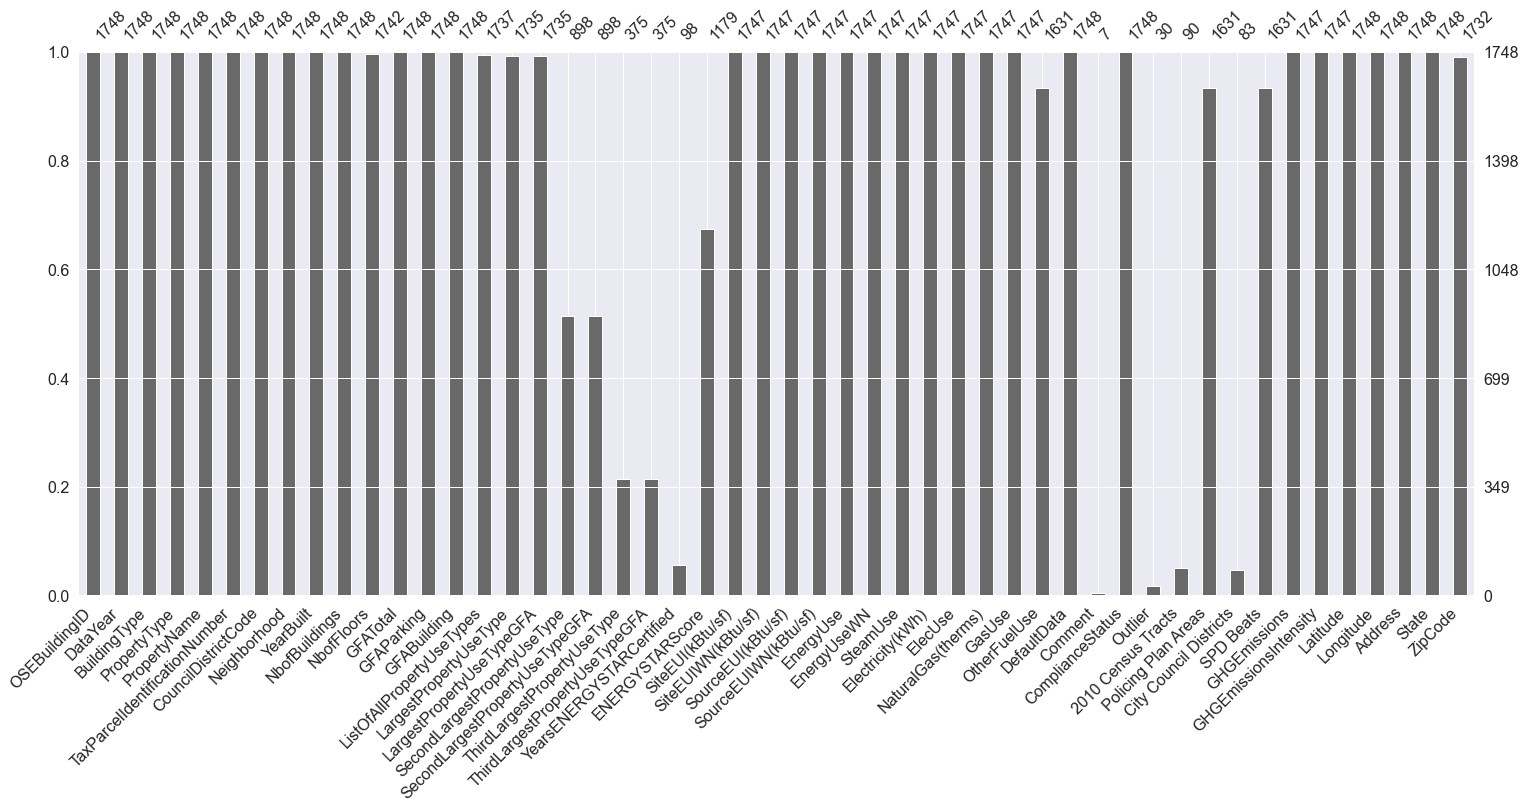

In [75]:
# Visualising missing data
msno.bar(data)

In [76]:
# Removing columns with no or few data or irrelevant data 
for column in data.columns:
    if (data[column].isna().mean() > 0.4):
        data.drop(columns = column, inplace = True)

<AxesSubplot:>

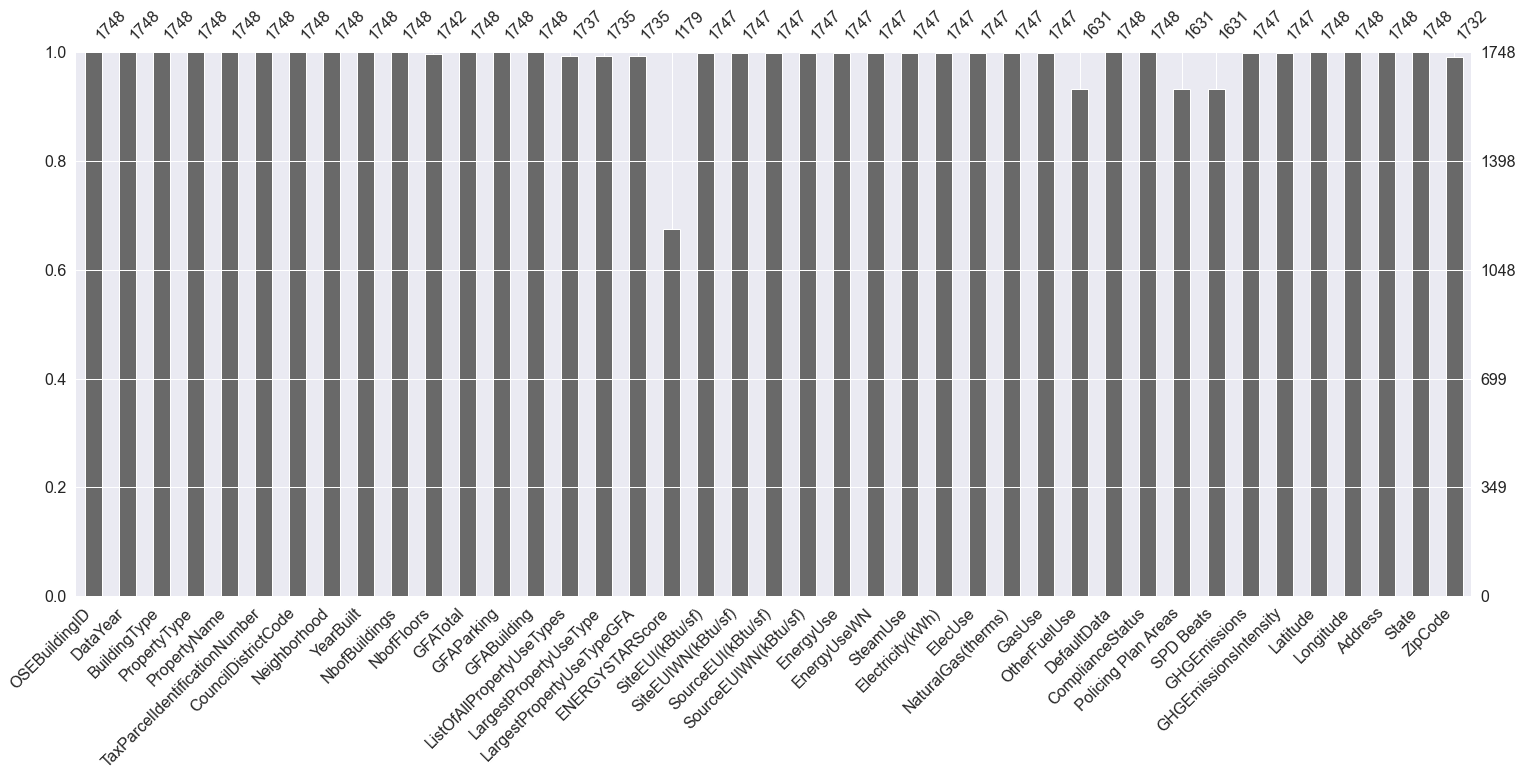

In [77]:
# Visualising NaNs
msno.bar(data)

In [78]:
# Analysing quantitative variables
data.describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NbofBuildings,NbofFloors,GFATotal,GFAParking,GFABuilding,LargestPropertyUseTypeGFA,...,ElecUse,NaturalGas(therms),GasUse,OtherFuelUse,DefaultData,ComplianceStatus,Policing Plan Areas,SPD Beats,GHGEmissions,GHGEmissionsIntensity
count,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1742.000000,1.748000e+03,1748.000000,1.748000e+03,1.735000e+03,...,1.747000e+03,1.747000e+03,1.747000e+03,1.631000e+03,1748.000000,1748.000000,1631.000000,1631.000000,1747.000000,1747.000000
mean,16694.962815,2015.066362,4.374142,1962.449657,1.120137,4.153272,1.186435e+05,14015.737414,1.046278e+05,9.885016e+04,...,5.847120e+06,1.942493e+04,1.942493e+06,1.438509e+04,0.116133,0.991419,34.551809,25.689761,183.500555,1.393721
std,13871.144088,0.248984,2.188761,32.993213,2.838404,6.470277,2.917511e+05,44706.965442,2.765008e+05,2.730406e+05,...,2.059656e+07,9.224259e+04,9.224260e+06,2.802621e+05,0.320476,0.092263,19.526596,13.906899,739.361819,2.279027
min,1.000000,2015.000000,1.000000,1900.000000,0.000000,0.000000,1.128500e+04,-2.000000,-5.055000e+04,5.872000e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,599.750000,2015.000000,2.000000,1930.000000,1.000000,1.000000,2.963475e+04,0.000000,2.852325e+04,2.550000e+04,...,7.393560e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,14.000000,12.000000,19.810000,0.185000
50%,21220.000000,2015.000000,4.000000,1966.000000,1.000000,2.000000,4.995050e+04,0.000000,4.792750e+04,4.381300e+04,...,1.664583e+06,4.815000e+03,4.815260e+05,0.000000e+00,0.000000,1.000000,36.000000,27.000000,49.010000,0.680000
75%,24708.500000,2015.000000,7.000000,1990.000000,1.000000,4.000000,1.083720e+05,0.000000,9.569800e+04,9.206750e+04,...,4.843426e+06,1.491400e+04,1.491398e+06,0.000000e+00,0.000000,1.000000,54.000000,37.000000,138.775000,1.640000
max,50226.000000,2016.000000,7.000000,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,...,6.570744e+08,2.979090e+06,2.979090e+08,8.269669e+06,1.000000,1.000000,61.000000,51.000000,16870.980000,34.090000


In [79]:
# Analysing qualitative variables
COL_QUAL = data.select_dtypes(include = ['object']).columns.tolist()
data[COL_QUAL].describe()

,BuildingType,PropertyType,PropertyName,TaxParcelIdentificationNumber,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,Latitude,Longitude,Address,State,ZipCode
count,1748,1748,1748,1748,1748,1737,1735,1748,1748,1748,1748,1732
unique,8,63,1709,1667,7,380,57,1681,1663,1698,2,52
top,NonResidential,Small- and Mid-Sized Office,WAREHOUSE,1625049001,SOUTHEAST,Office,Office,47.52593209,-122.3308402,2623 ne university village st,wa,98134
freq,1485,302,9,8,401,147,512,5,5,8,1632,189


C:\Users\najwa\AppData\Local\Temp\ipykernel_11852\3159751091.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


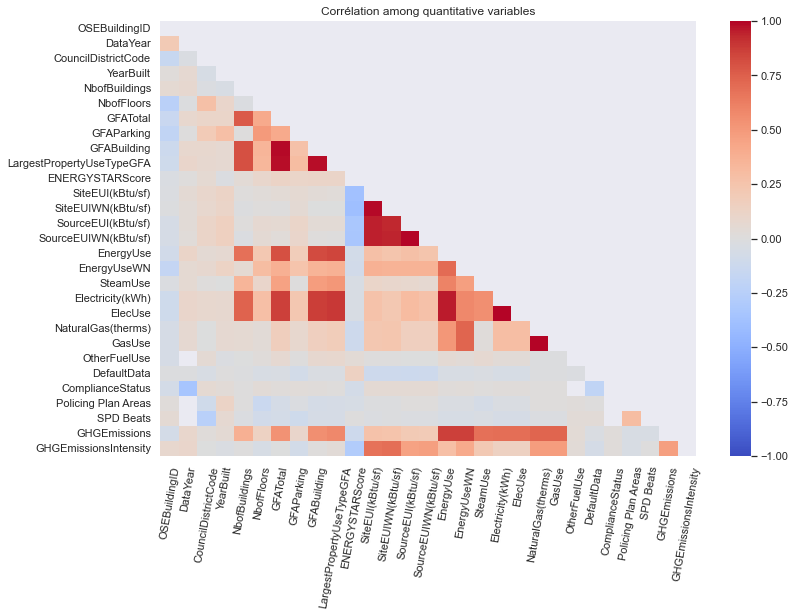

In [80]:
# Displaying heatmap correlation between quantitative variables
plt.figure(figsize=(12,8))
plt.title('Corrélation among quantitative variables', fontsize = 12)

corr = data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 

ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm')
plt.xticks(rotation=80)
plt.show()
sns.set(font_scale=1)

In [81]:
# Identifying targets for our mission
COL_TARGET = ['EnergyUse','EnergyUseWN', 'GHGEmissions']

In [82]:
# Reminding columns
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NbofBuildings', 'NbofFloors', 'GFATotal',
       'GFAParking', 'GFABuilding', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'EnergyUse',
       'EnergyUseWN', 'SteamUse', 'Electricity(kWh)', 'ElecUse',
       'NaturalGas(therms)', 'GasUse', 'OtherFuelUse', 'DefaultData',
       'ComplianceStatus', 'Policing Plan Areas', 'SPD Beats', 'GHGEmissions',
       'GHGEmissionsIntensity', 'Latitude', 'Longitude', 'Address', 'State',
       'ZipCode'],
      dtype='object')

In [83]:
# Identifying relevant features - not linked to targets and with few modalities
COL_FEATURE = ['DataYear', 'PropertyType',
       'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NbofBuildings', 'NbofFloors', 'GFATotal',
       'GFAParking', 'GFABuilding', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SteamUse', 'ElecUse', 'GasUse', 'OtherFuelUse', 'DefaultData',
       'ComplianceStatus']

In [84]:
# Reducing Data to targets and features identified relevant
COL_SELECT = COL_TARGET + COL_FEATURE
data = data[COL_SELECT]

# <a name="C7">Cleaning</a>

### Handling NaNs

In [85]:
# Analysing quantitative variables
data.describe()

,EnergyUse,EnergyUseWN,GHGEmissions,DataYear,CouncilDistrictCode,YearBuilt,NbofBuildings,NbofFloors,GFATotal,GFAParking,GFABuilding,LargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse,ElecUse,GasUse,OtherFuelUse,DefaultData,ComplianceStatus
count,1.747000e+03,1.747000e+03,1747.000000,1748.000000,1748.000000,1748.000000,1748.000000,1742.000000,1.748000e+03,1748.000000,1.748000e+03,1.735000e+03,1179.000000,1.747000e+03,1.747000e+03,1.747000e+03,1.631000e+03,1748.000000,1748.000000
mean,8.410164e+06,8.107517e+06,183.500555,2015.066362,4.374142,1962.449657,1.120137,4.153272,1.186435e+05,14015.737414,1.046278e+05,9.885016e+04,64.899915,5.126922e+05,5.847120e+06,1.942493e+06,1.438509e+04,0.116133,0.991419
std,2.988891e+07,2.207180e+07,739.361819,0.248984,2.188761,32.993213,2.838404,6.470277,2.917511e+05,44706.965442,2.765008e+05,2.730406e+05,28.432391,5.357066e+06,2.059656e+07,9.224260e+06,2.802621e+05,0.320476,0.092263
min,0.000000e+00,0.000000e+00,0.000000,2015.000000,1.000000,1900.000000,0.000000,0.000000,1.128500e+04,-2.000000,-5.055000e+04,5.872000e+03,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.225494e+06,1.357527e+06,19.810000,2015.000000,2.000000,1930.000000,1.000000,1.000000,2.963475e+04,0.000000,2.852325e+04,2.550000e+04,47.500000,0.000000e+00,7.393560e+05,0.000000e+00,0.000000e+00,0.000000,1.000000
50%,2.513155e+06,2.704889e+06,49.010000,2015.000000,4.000000,1966.000000,1.000000,2.000000,4.995050e+04,0.000000,4.792750e+04,4.381300e+04,72.000000,0.000000e+00,1.664583e+06,4.815260e+05,0.000000e+00,0.000000,1.000000
75%,6.820109e+06,7.085417e+06,138.775000,2015.000000,7.000000,1990.000000,1.000000,4.000000,1.083720e+05,0.000000,9.569800e+04,9.206750e+04,89.000000,0.000000e+00,4.843426e+06,1.491398e+06,0.000000e+00,0.000000,1.000000
max,8.739237e+08,4.716139e+08,16870.980000,2016.000000,7.000000,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,100.000000,1.278697e+08,6.570744e+08,2.979090e+08,8.269669e+06,1.000000,1.000000


In [86]:
# Displaying NaNs
data.isna().sum()

EnergyUse                      1
EnergyUseWN                    1
GHGEmissions                   1
DataYear                       0
PropertyType                   0
CouncilDistrictCode            0
Neighborhood                   0
YearBuilt                      0
NbofBuildings                  0
NbofFloors                     6
GFATotal                       0
GFAParking                     0
GFABuilding                    0
LargestPropertyUseType        13
LargestPropertyUseTypeGFA     13
ENERGYSTARScore              569
SteamUse                       1
ElecUse                        1
GasUse                         1
OtherFuelUse                 117
DefaultData                    0
ComplianceStatus               0
dtype: int64

In [87]:
# Dispalying building with unknown energyuse
data.loc[data['EnergyUse'].isna(),:]

,EnergyUse,EnergyUseWN,GHGEmissions,DataYear,PropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NbofBuildings,NbofFloors,...,GFABuilding,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse,ElecUse,GasUse,OtherFuelUse,DefaultData,ComplianceStatus
2108,NaN,NaN,NaN,2015,K-12 School,5,NORTHWEST,1953,1.0,1.0,...,110830,K-12 School,110830.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [88]:
# Removing this building
data.drop(index=2108,inplace=True)

In [89]:
# Assigning values to NaNs.
#if no OtherFuelUse; no NbFloors advised, we suppose then it is none so 0.
data['OtherFuelUse'] = np.where(data['OtherFuelUse'].isna(), 0, data['OtherFuelUse'])
data['NbofFloors'] = np.where(data['NbofFloors'].isna(), 0, data['NbofFloors'])#
#If LargestPropertyUseType not advised, we suppose same as GFA Total and PRopertyType
data['LargestPropertyUseTypeGFA'] = np.where(data['LargestPropertyUseTypeGFA'].isna(), data['GFATotal'], data['LargestPropertyUseTypeGFA'])
data['LargestPropertyUseType'] = np.where(data['LargestPropertyUseType'].isna(), data['PropertyType'], data['LargestPropertyUseTypeGFA'])

In [90]:
# Displaying NaNs
data.isna().sum()

EnergyUse                      0
EnergyUseWN                    0
GHGEmissions                   0
DataYear                       0
PropertyType                   0
CouncilDistrictCode            0
Neighborhood                   0
YearBuilt                      0
NbofBuildings                  0
NbofFloors                     0
GFATotal                       0
GFAParking                     0
GFABuilding                    0
LargestPropertyUseType         0
LargestPropertyUseTypeGFA      0
ENERGYSTARScore              568
SteamUse                       0
ElecUse                        0
GasUse                         0
OtherFuelUse                   0
DefaultData                    0
ComplianceStatus               0
dtype: int64

### Handling outliers

In [91]:
# Analysing quantitative variables
data.describe()

,EnergyUse,EnergyUseWN,GHGEmissions,DataYear,CouncilDistrictCode,YearBuilt,NbofBuildings,NbofFloors,GFATotal,GFAParking,GFABuilding,LargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse,ElecUse,GasUse,OtherFuelUse,DefaultData,ComplianceStatus
count,1.747000e+03,1.747000e+03,1747.000000,1747.00000,1747.000000,1747.000000,1747.000000,1747.000000,1.747000e+03,1747.000000,1.747000e+03,1.747000e+03,1179.000000,1.747000e+03,1.747000e+03,1.747000e+03,1.747000e+03,1747.000000,1747.000000
mean,8.410164e+06,8.107517e+06,183.500555,2015.06640,4.373784,1962.455066,1.120206,4.140813,1.186480e+05,14023.760160,1.046243e+05,9.849000e+04,64.899915,5.126922e+05,5.847120e+06,1.942493e+06,1.342993e+04,0.115627,0.991414
std,2.988891e+07,2.207180e+07,739.361819,0.24905,2.189337,33.001885,2.839215,6.465140,2.918346e+05,44718.507619,2.765799e+05,2.721437e+05,28.432391,5.357066e+06,2.059656e+07,9.224260e+06,2.708159e+05,0.319868,0.092289
min,0.000000e+00,0.000000e+00,0.000000,2015.00000,1.000000,1900.000000,0.000000,0.000000,1.128500e+04,-2.000000,-5.055000e+04,5.872000e+03,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.225494e+06,1.357527e+06,19.810000,2015.00000,2.000000,1930.000000,1.000000,1.000000,2.963350e+04,0.000000,2.851550e+04,2.550000e+04,47.500000,0.000000e+00,7.393560e+05,0.000000e+00,0.000000e+00,0.000000,1.000000
50%,2.513155e+06,2.704889e+06,49.010000,2015.00000,4.000000,1966.000000,1.000000,2.000000,4.995000e+04,0.000000,4.786300e+04,4.381300e+04,72.000000,0.000000e+00,1.664583e+06,4.815260e+05,0.000000e+00,0.000000,1.000000
75%,6.820109e+06,7.085417e+06,138.775000,2015.00000,7.000000,1990.000000,1.000000,4.000000,1.081405e+05,0.000000,9.555000e+04,9.191750e+04,89.000000,0.000000e+00,4.843426e+06,1.491398e+06,0.000000e+00,0.000000,1.000000
max,8.739237e+08,4.716139e+08,16870.980000,2016.00000,7.000000,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,100.000000,1.278697e+08,6.570744e+08,2.979090e+08,8.269669e+06,1.000000,1.000000


In [92]:
# Identifying outliers identified
data[data.NbofFloors==99]

,EnergyUse,EnergyUseWN,GHGEmissions,DataYear,PropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NbofBuildings,NbofFloors,...,GFABuilding,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse,ElecUse,GasUse,OtherFuelUse,DefaultData,ComplianceStatus
1371,318205.0,318205.0,2.22,2015,Worship Facility,2,SOUTHEAST,1977,1.0,99.0,...,21948,21948.0,21948.0,54.0,0.0,318218.0,0.0,0.0,1.0,1.0


In [93]:
# Identifying further the building
data_or[data_or.NumberofFloors==99]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,City Council Districts,SPD Beats,TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address,City,State,ZipCode
1371,21611,2015,NonResidential,Worship Facility,CHINESE BAPTIST CHURCH,2124049098,2,SOUTHEAST,1977,1.0,...,NaN,44.0,2.22,0.04,47.55057128,-122.302943,5801 beacon ave s,seattle,wa,98108
4699,21611,2016,NonResidential,Worship Facility,Seattle Chinese Baptist Church,2124049098,2,SOUTHEAST,1977,1.0,...,NaN,NaN,2.27,0.10,47.55072,-122.30265,5801 Beacon Avenue South,Seattle,WA,98108.0


In [94]:
# Correcting the outlier (via internet search)
data.loc[1371,'NbofFloors'] = 1

In [95]:
# Assigning values to outliers
# IfNbBuilding = 0, we suppose it means there is 1
# If GFAParking is negative, we suppose it means it is 0.
# If GFABuilding is negative, we compute it
data['NbofBuildings'] = np.where(data['NbofBuildings']==0, 1, data['NbofBuildings'])
data['GFAParking'] = np.where(data['GFAParking']<0, 0, data['GFAParking'])
data['GFABuilding'] = np.where(data['GFABuilding']<0, data['GFATotal']-data['GFAParking'], data['GFABuilding'])

In [96]:
# Displaying the buildings whose Parking is more than GFATotal
data[data.GFAParking>data.GFATotal]

,EnergyUse,EnergyUseWN,GHGEmissions,DataYear,PropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NbofBuildings,NbofFloors,...,GFABuilding,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse,ElecUse,GasUse,OtherFuelUse,DefaultData,ComplianceStatus
3322,1389553.0,1389553.0,9.69,2015,Parking,4,NORTHEAST,2014,1.0,3.0,...,-50550,83600.0,83600.0,NaN,0.0,1389610.0,0.0,0.0,0.0,1.0
3139,3455247.0,3455247.0,24.09,2015,Small- and Mid-Sized Office,7,MAGNOLIA / QUEEN ANNE,1982,1.0,5.0,...,-43310,54015.0,54015.0,65.0,0.0,3455391.0,0.0,0.0,0.0,1.0


In [97]:
# Correcting a building
data.loc[3322,'GFATotal'] = data.loc[3322,'GFAParking']
data.loc[3322,'GFABuilding'] = 0

In [98]:
# Deleting an outlier
data = data[data.GFAParking<data.GFATotal]

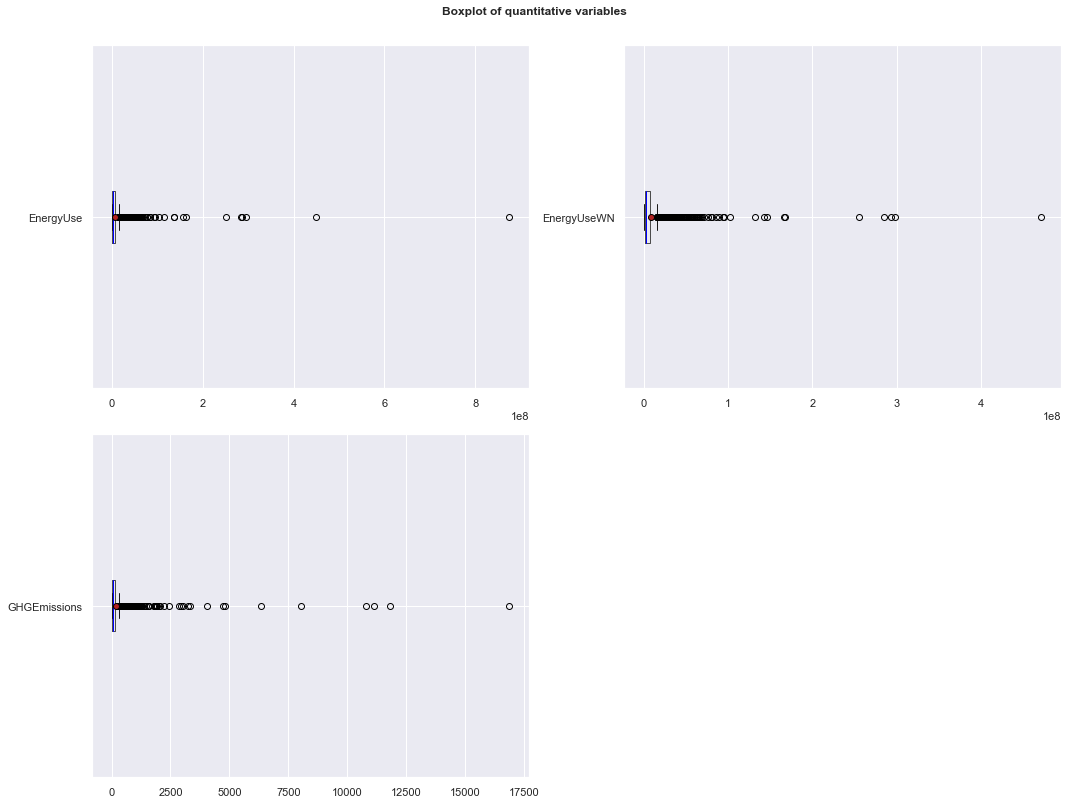

In [99]:
# Analysing order of magnitude for each target variable 
fig = plt.figure(figsize=(15,12))

COL = ['EnergyUse',
 'EnergyUseWN',
 'GHGEmissions']

medianprops = {'color':"blue"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}


for i, col in enumerate(COL,1):
    ax = fig.add_subplot(2,2,i)
    data_temp = data[[col]]
    data_temp.boxplot(showfliers=True, medianprops=medianprops, vert=False, showmeans=True, meanprops=meanprops, ax=ax)
   
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Boxplot of quantitative variables', fontsize=12,
             fontweight='bold')

plt.show()

In [100]:
# Creating a variable - energy consumption per square feet - to remove any outliers
data['EnergyRate'] = data['EnergyUse']/data['GFABuilding']

In [101]:
# Creating a variable - GHG emission per square feet - to remove any outliers
data['GHGRate'] = data['GHGEmissions']/data['GFABuilding']

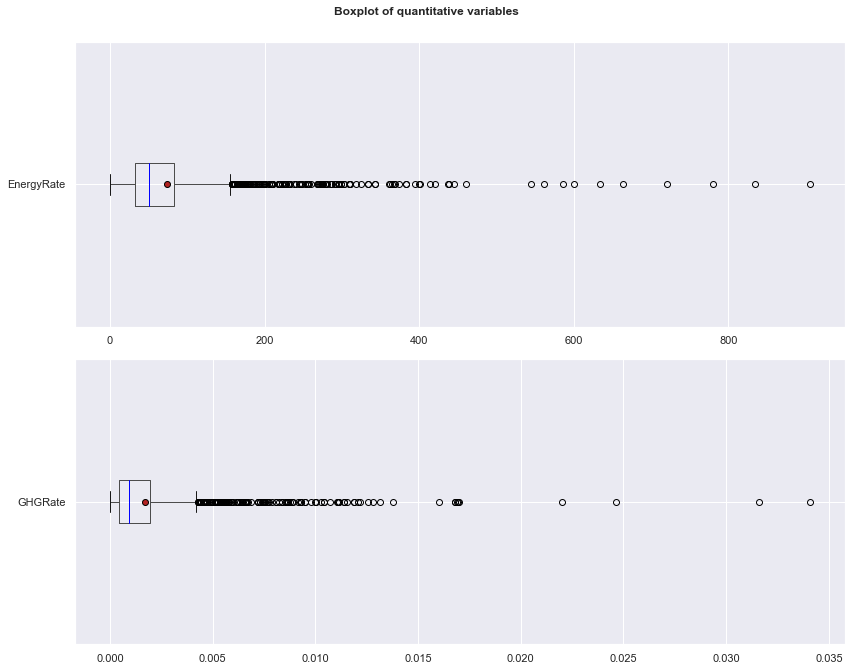

In [102]:
# Analysing order of magnitude for each created variable, to best identify outliers
COL2 = ['EnergyRate','GHGRate']
fig = plt.figure(figsize=(12,10))

medianprops = {'color':"blue"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

for i, col in enumerate(COL2,1):
    ax = fig.add_subplot(2,1,i)
    data_temp = data[[col]]
    data_temp.boxplot(showfliers=True, medianprops=medianprops, 
            vert=False, showmeans=True, meanprops=meanprops, ax=ax)
    
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Boxplot of quantitative variables', fontsize=12,
             fontweight='bold')

plt.show()

C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


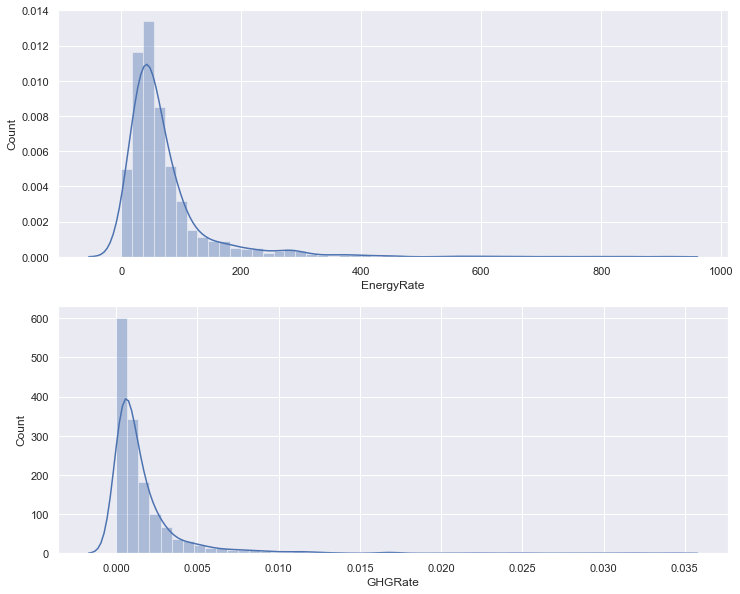

In [103]:
# Analysing order of magnitude for each created variable - histogram
fig = plt.figure(figsize=(12,10))

for i, col in enumerate(COL2,1):
    ax = fig.add_subplot(2,1,i)
    #data_temp = data[[col]]
    #plt.hist(data_temp,rwidth=0.8)
    sns.distplot(data[col])
    plt.xlabel(col)
    plt.ylabel("Count")
    
plt.show()

In [104]:
# Listing quantitative variables
COL_QUANT = data.select_dtypes(include = ['int64','float64']).columns.tolist()

C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


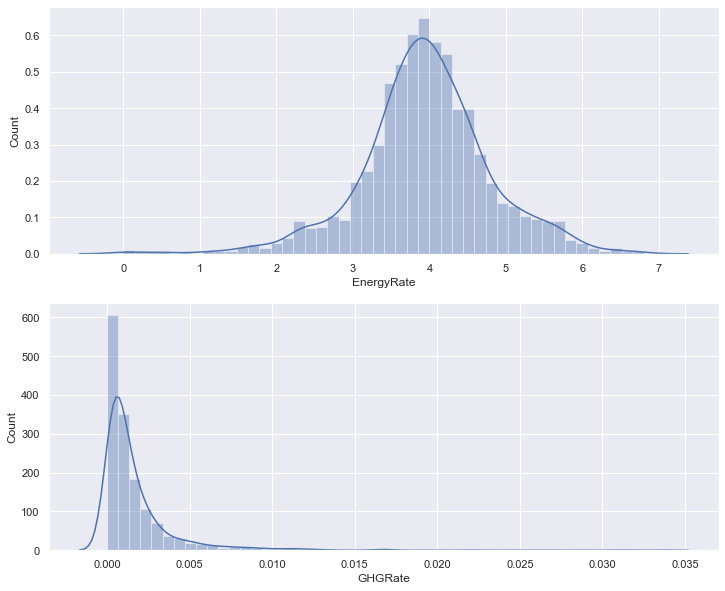

In [105]:
# Transforming created variable créées into log
fig = plt.figure(figsize=(12,10))

for i, col in enumerate(COL2,1):
    ax = fig.add_subplot(2,1,i)
    sns.distplot(np.log1p(data[col]))
    plt.xlabel(col)
    plt.ylabel("Count")
    
plt.show()

In [106]:
# Removing outliers using Zscore on EnergyRate log
data['EnergyRateLog'] = np.log1p(data['EnergyRate'])
data['zscore'] = (data.EnergyRateLog - data.EnergyRateLog.mean())/data.EnergyRateLog.std()   
data = data[(data.zscore>-3) & (data.zscore<3)]
data.shape

(1728, 26)

In [107]:
# Removing outliers using Zscore on GHGRate log
data['GHGRateLog'] = np.log1p(data['GHGRate'])
data['zscore'] = (data.GHGRateLog - data.GHGRateLog.mean())/data.GHGRateLog.std()   
data = data[(data.zscore>-3) & (data.zscore<3)]
data.shape

(1687, 27)

In [108]:
# Deleting columns created to identify outliers
data = data.drop(['GHGRateLog','EnergyRateLog','zscore','GHGRate','EnergyRate'],axis='columns')

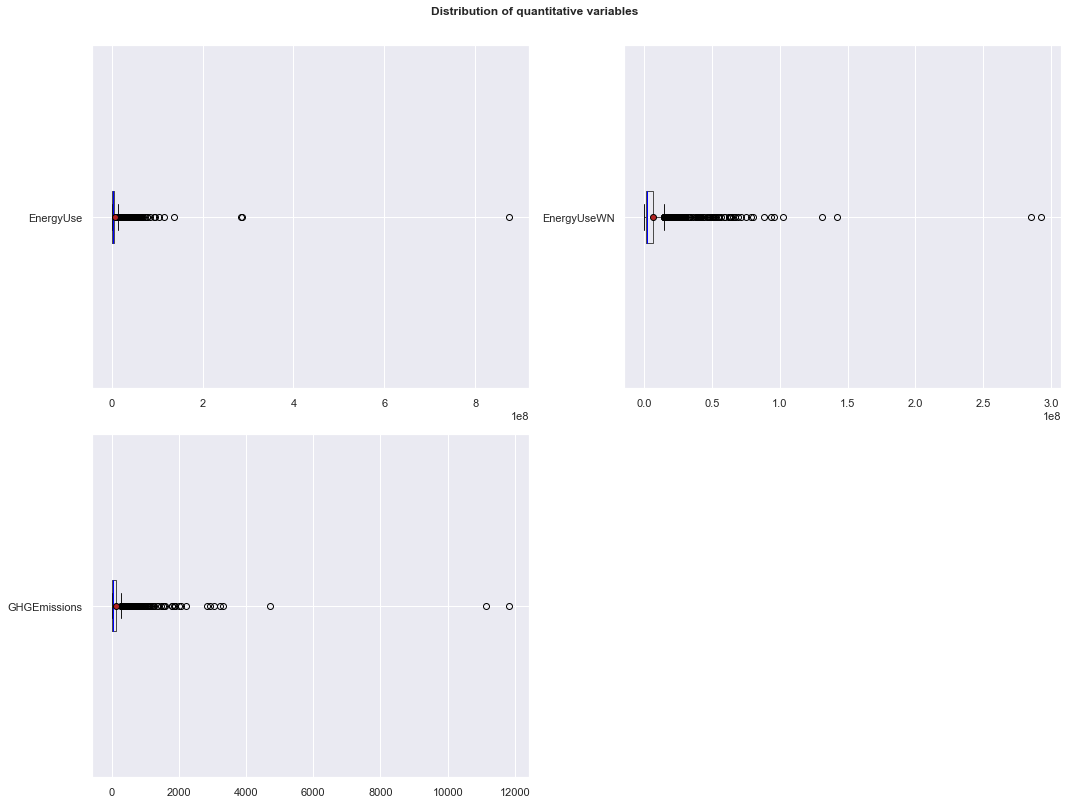

In [109]:
# Analysing order of magnitude for eacg target variable after removal of outliers
fig = plt.figure(figsize=(15,12))

COL = ['EnergyUse',
 'EnergyUseWN',
 'GHGEmissions']

for i, col in enumerate(COL,1):
    ax = fig.add_subplot(2,2,i)
    data_temp = data[[col]]
    data_temp.boxplot(showfliers=True, medianprops=medianprops, vert=False, showmeans=True, meanprops=meanprops, ax=ax)
    #ax.hist(data[col],  bins=50)
    #sns.di#stplot(data[col])
    #plt.xlabel(col)
    #ax.set_title(col)
    #ax.vlines(data[col].median(), *ax.get_ylim(), color='red', ls='-', lw=1.5)
    #ax.vlines(data[col].mean(), *ax.get_ylim(),  color='green', ls='-.', lw=1.5)
    #ax.vlines(data[col].mode()[0], *ax.get_ylim(), color='yellow', ls='--', lw=1.5)
    #ax.legend(['mediane','moyenne','mode'])

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of quantitative variables', fontsize=12,
             fontweight='bold')

plt.show()

In [110]:
# Identifying more outliers
data[data.EnergyUse>2e8]

,EnergyUse,EnergyUseWN,GHGEmissions,DataYear,PropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NbofBuildings,NbofFloors,...,GFABuilding,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse,ElecUse,GasUse,OtherFuelUse,DefaultData,ComplianceStatus
560,284867168.0,284867168.0,1992.96,2015,Data Center,7,DOWNTOWN,1981,1.0,33.0,...,429405,218997.0,218997.0,71.0,0.0,284726322.0,152639.0,0.0,0.0,1.0
621,286685536.0,292746272.0,11824.89,2015,Hospital,3,CENTRAL,1994,1.0,14.0,...,1765970,1639334.0,1639334.0,59.0,127869744.0,140448322.0,18373320.0,0.0,0.0,1.0
6614,873923712.0,0.0,11140.56,2016,University,4,NORTHEAST,1900,111.0,0.0,...,9320156,9320156.0,9320156.0,NaN,84985240.0,657074389.0,0.0,0.0,0.0,1.0


In [111]:
# Removing these outliers in view of their small number and size
data = data[data.EnergyUse<2e8]

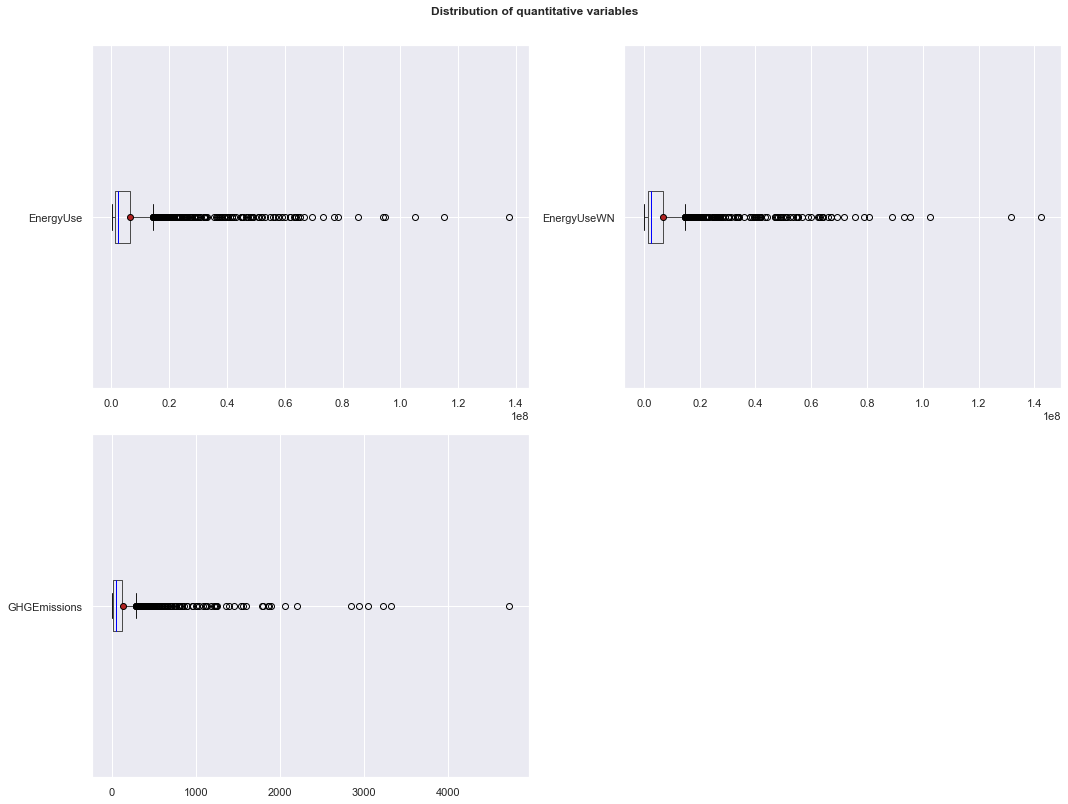

In [112]:
# Analysing orders of magnitude for each target variable after removing the visual outliers of these variables
fig = plt.figure(figsize=(15,12))

COL = ['EnergyUse',
 'EnergyUseWN',
 'GHGEmissions']

for i, col in enumerate(COL,1):
    ax = fig.add_subplot(2,2,i)
    data_temp = data[[col]]
    data_temp.boxplot(showfliers=True, medianprops=medianprops, vert=False, showmeans=True, meanprops=meanprops, ax=ax)
    #ax.hist(data[col],  bins=50)
    #sns.di#stplot(data[col])
    #plt.xlabel(col)
    #ax.set_title(col)
    #ax.vlines(data[col].median(), *ax.get_ylim(), color='red', ls='-', lw=1.5)
    #ax.vlines(data[col].mean(), *ax.get_ylim(),  color='green', ls='-.', lw=1.5)
    #ax.vlines(data[col].mode()[0], *ax.get_ylim(), color='yellow', ls='--', lw=1.5)
    #ax.legend(['mediane','moyenne','mode'])

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of quantitative variables', fontsize=12,
             fontweight='bold')

plt.show()

<AxesSubplot:>

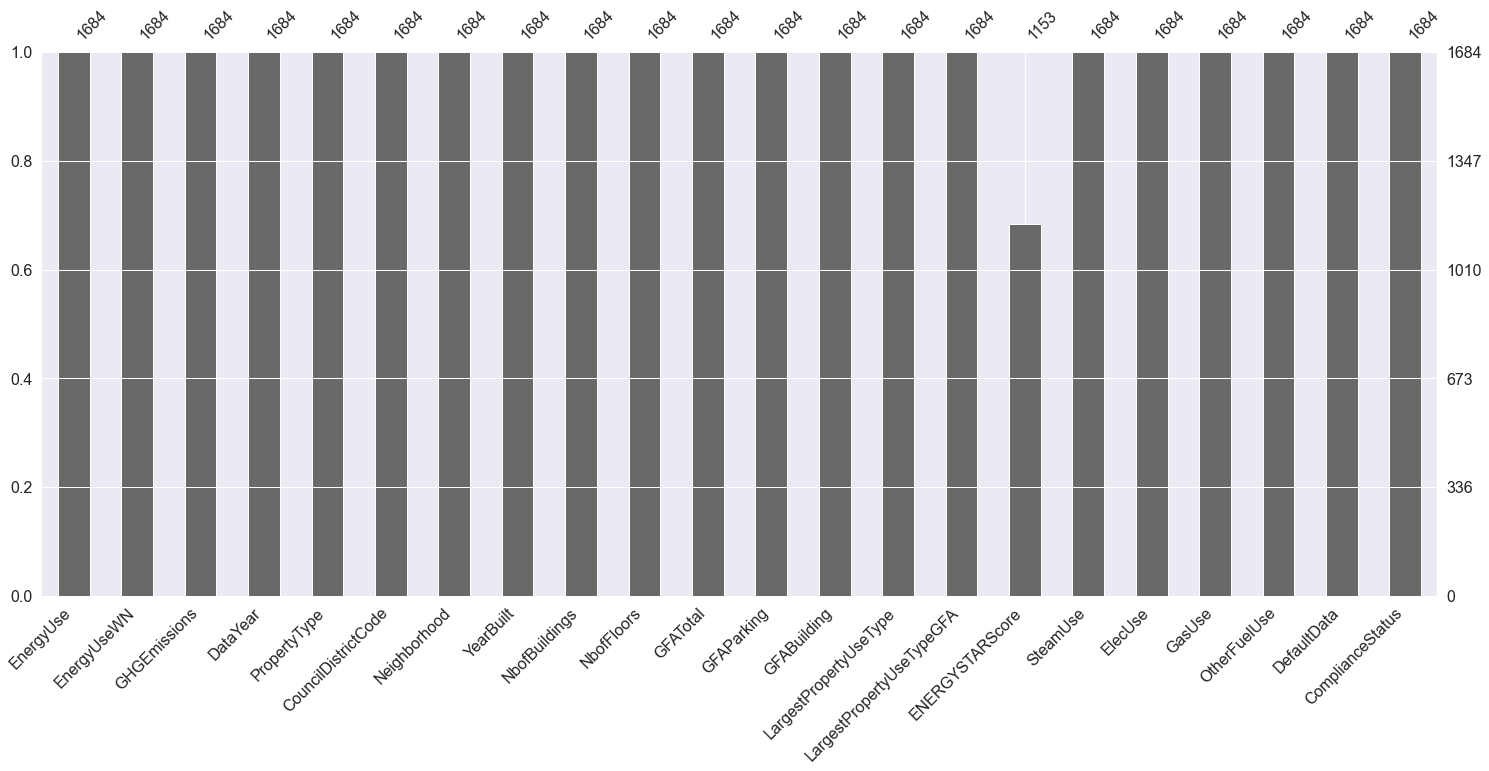

In [113]:
# Visualising NaNs
msno.bar(data)

In [114]:
# Displaying data shape
data.shape

(1684, 22)

In [115]:
# Displaying percentage of NaN in data
data.isna().mean().mean()

0.014332757503778881

# Part 2 : Feature Engineering

# <a name="C7">Creation of new variables</a>

In [116]:
# Analysing quantitative variables
data.describe()

,EnergyUse,EnergyUseWN,GHGEmissions,DataYear,CouncilDistrictCode,YearBuilt,NbofBuildings,NbofFloors,GFATotal,GFAParking,GFABuilding,LargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse,ElecUse,GasUse,OtherFuelUse,DefaultData,ComplianceStatus
count,1.684000e+03,1.684000e+03,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1.684000e+03,1684.000000,1.684000e+03,1.684000e+03,1153.000000,1.684000e+03,1.684000e+03,1.684000e+03,1.684000e+03,1684.000000,1684.000000
mean,6.559581e+06,6.715273e+06,131.158729,2015.062352,4.364014,1962.545131,1.057601,4.083135,1.116624e+05,13782.274347,9.788014e+04,9.056710e+04,65.307025,2.250572e+05,4.786316e+06,1.514235e+06,1.392903e+04,0.119952,0.992280
std,1.184994e+07,1.200168e+07,293.455672,0.241865,2.191359,32.920867,1.076242,6.070607,1.859861e+05,43883.872092,1.604353e+05,1.489244e+05,28.070461,1.543153e+06,8.885368e+06,4.226049e+06,2.758255e+05,0.325002,0.087548
min,8.282400e+04,0.000000e+00,0.000000,2015.000000,1.000000,1900.000000,1.000000,0.000000,1.128500e+04,0.000000,1.092500e+04,5.872000e+03,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.220490e+06,1.356185e+06,19.750000,2015.000000,2.000000,1930.000000,1.000000,1.000000,2.959550e+04,0.000000,2.856250e+04,2.549525e+04,48.000000,0.000000e+00,7.372478e+05,0.000000e+00,0.000000e+00,0.000000,1.000000
50%,2.443040e+06,2.635972e+06,47.745000,2015.000000,4.000000,1966.000000,1.000000,2.000000,4.998250e+04,0.000000,4.800350e+04,4.373700e+04,73.000000,0.000000e+00,1.620186e+06,4.744680e+05,0.000000e+00,0.000000,1.000000
75%,6.445964e+06,6.691302e+06,128.510000,2015.000000,7.000000,1990.000000,1.000000,4.000000,1.079565e+05,0.000000,9.508625e+04,9.190875e+04,89.000000,0.000000e+00,4.666060e+06,1.404408e+06,0.000000e+00,0.000000,1.000000
max,1.376357e+08,1.424943e+08,4725.430000,2016.000000,7.000000,2015.000000,39.000000,76.000000,2.200000e+06,512608.000000,2.200000e+06,1.719643e+06,100.000000,3.265999e+07,9.075488e+07,8.162192e+07,8.269669e+06,1.000000,1.000000


In [117]:
# Creating a variable - building age
data['Age'] = data['DataYear']-data['YearBuilt']
data = data.drop(['DataYear','YearBuilt'],axis='columns')

In [118]:
# Creating a variable - floorGFA
data['FloorGFA'] = data['GFABuilding']/(data['NbofFloors']+1)

In [119]:
# Creating a variable - Parkingratio
data['ParkingRatio'] = data['GFAParking']/data['GFATotal']

# <a name="C8">Combining of modalities</a>

In [120]:
# Displaying nb of modalities of PropertyType
data.PropertyType.value_counts().to_dict()

{'Small- and Mid-Sized Office': 300,
 'Non-Refrigerated Warehouse': 182,
 'Large Office': 177,
 'K-12 School': 138,
 'Mixed Use Property': 124,
 'Retail Store': 101,
 'Hotel': 74,
 'Worship Facility': 71,
 'Other': 58,
 'Distribution Center': 53,
 'Senior Care Community': 45,
 'Medical Office': 41,
 'Supermarket/Grocery Store': 28,
 'Parking': 26,
 'Self-Storage Facility': 26,
 'College/University': 21,
 'Other - Recreation': 18,
 'Other - Entertainment/Public Assembly': 18,
 'Residence Hall/Dormitory': 15,
 'Office': 13,
 'Refrigerated Warehouse': 12,
 'Restaurant': 10,
 'Social/Meeting Hall': 8,
 'Residence Hall': 8,
 'Manufacturing/Industrial Plant': 8,
 'Repair Services (Vehicle, Shoe, Locksmith, etc)': 7,
 'Warehouse': 6,
 'Automobile Dealership': 6,
 'Other - Lodging/Residential': 6,
 'Hospital': 6,
 'Other - Services': 5,
 'Strip Mall': 5,
 'Laboratory': 5,
 'Other/Specialty Hospital': 4,
 'Museum': 4,
 'Performing Arts': 4,
 'Library': 4,
 'Financial Office': 4,
 'Urgent Care/C

In [121]:
# Checking the nu of modalities
len(data.PropertyType.unique())

63

In [122]:
# Checking list of modalities wwith a nb below 201
stats = data.groupby('PropertyType')['PropertyType'].agg('count').sort_values(ascending=False)
stats[stats <=201]

PropertyType
Non-Refrigerated Warehouse                              182
Large Office                                            177
K-12 School                                             138
Mixed Use Property                                      124
Retail Store                                            101
                                                       ... 
Fire Station                                              1
Data Center                                               1
Personal Services (Health/Beauty, Dry Cleaning, etc)      1
Convention Center                                         1
Wholesale Club/Supercenter                                1
Name: PropertyType, Length: 62, dtype: int64

In [123]:
# Gruping modalities by "logic" in terms of energy consumption
data.loc[data['PropertyType'].str.contains("Convention Center|Movie Theater|Lifestyle Center|Fitness Center/Health Club/Gym|Mall|Performing Arts|Library|Museum|Meeting Hall|Entertainment/Public Assembly|Recreation|Supercenter")==True,'PropertyType'] = "Leisure"
data.loc[data['PropertyType'].str.contains("Services|Automobile Dealership|Bank|Utility|Courthouse|Outpatient Rehabilitation/Physical Therapy")==True,'PropertyType'] = "Services"
data.loc[data['PropertyType']== "Office",'PropertyType'] = "Small- and Mid-Sized Office"
data.loc[data['PropertyType']== "Financial Office",'PropertyType'] = "Small- and Mid-Sized Office"
data.loc[data['PropertyType']== "Medical Office",'PropertyType'] = "Small- and Mid-Sized Office"
data.loc[data['PropertyType'].str.contains("Supermarket|Restaurant|Food")==True,'PropertyType'] = "Food"
data.loc[data['PropertyType'].str.contains("University|School|Education|Daycare|SPS")==True,'PropertyType'] = "Education"
data.loc[data['PropertyType'].str.contains("Refrigerated Warehouse|Hospital|Laboratory|Distribution Center|Data Center|Fire Station|Urgent|Police")==True,'PropertyType'] = "247Essential"
data.loc[data['PropertyType'].str.contains("Hotel|Dormitory|Residence|Senior|Residential")==True,'PropertyType'] = "Accommodation"
data.loc[data['PropertyType'].str.contains("Non-Refrigerated Warehouse|Self-St|Residentialorage Facility|Warehouse|Prison")==True,'PropertyType'] = "247Nonessential"
data.loc[data['PropertyType'].str.contains("Plant")==True,'PropertyType'] = "Factory"

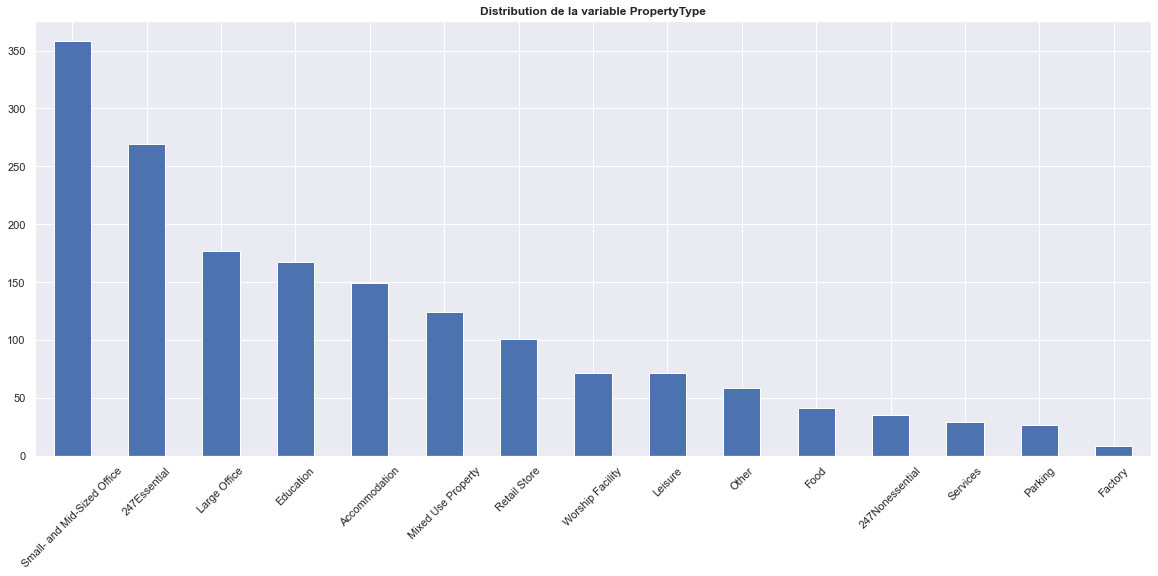

In [124]:
# Analysing modalities
fig = plt.figure(figsize=(20,8))
data['PropertyType'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Distribution de la variable PropertyType', fontsize=12,
             fontweight='bold')

plt.show()

# <a name="C10">Transformation of variables</a>

In [125]:
# Listing quantitative columns
COL_QUANT = data.select_dtypes(include = ['int64','float64']).columns.tolist()

In [126]:
# Transforming variables SteamUse, GasUse, ElecUse and OtherFuel strongly correlated to our target, indicating whether or not this mode of energy is present.
data['SteamUse'] = np.where(data['SteamUse']>0, 1, 0)
data['GasUse'] = np.where(data['GasUse']>0, 1, 0)
data['ElecUse'] = np.where(data['ElecUse']>0, 1, 0)
data['OtherFuelUse'] = np.where(data['OtherFuelUse']>0, 1, 0)

In [127]:
# Creating dummy columns for PropertyType
dummies = pd.get_dummies(data.PropertyType)

In [128]:
# Adding dummies variables to the data, removing the Factory dummy considered 00000
data = pd.concat([data,dummies.drop('Factory',axis='columns')],axis='columns')

In [129]:
# Checking the new dataset
data.head()

,EnergyUse,EnergyUseWN,GHGEmissions,PropertyType,CouncilDistrictCode,Neighborhood,NbofBuildings,NbofFloors,GFATotal,GFAParking,...,Food,Large Office,Leisure,Mixed Use Property,Other,Parking,Retail Store,Services,Small- and Mid-Sized Office,Worship Facility
124,3091559.0,3229387.0,80.49,Small- and Mid-Sized Office,5,NORTHWEST,1.0,3.0,55442,0,...,0,0,0,0,0,0,0,0,1,0
359,14583160.0,15302825.0,291.28,Retail Store,5,NORTHEAST,1.0,2.0,244529,0,...,0,0,0,0,0,0,1,0,0,0
3239,14935251.0,15934393.0,143.10,Large Office,7,DOWNTOWN,1.0,13.0,358259,149326,...,0,1,0,0,0,0,0,0,0,0
43,9213841.0,9213841.0,64.23,Large Office,7,DOWNTOWN,1.0,5.0,168115,0,...,0,1,0,0,0,0,0,0,0,0
207,40451748.0,0.0,282.01,Large Office,7,DOWNTOWN,1.0,33.0,791396,0,...,0,1,0,0,0,0,0,0,0,0


# Part 3 : Exploratory Analysis

# <a name="C10">Distribution of variables</a>

In [130]:
# Listing quantitative variables other than 0 and 1
COL_QUANT = ['EnergyUse',
 'EnergyUseWN',
 'GHGEmissions',
 'NbofBuildings',
 'NbofFloors',
 'GFATotal',
 'GFAParking',
 'GFABuilding',
 'LargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'Age',
 'FloorGFA',
 'ParkingRatio']

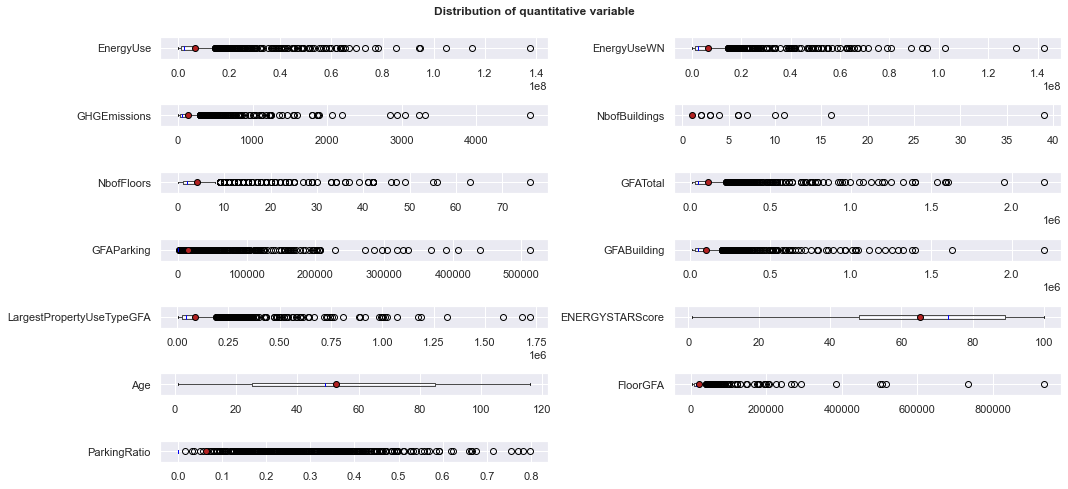

In [131]:
# Analysis of orders of magnitude for each of these variables
fig = plt.figure(figsize=(15,8))

for i, col in enumerate(COL_QUANT,1):
    ax = fig.add_subplot(8,2,i)
    data_temp = data[[col]]
    data_temp.boxplot(showfliers=True, medianprops=medianprops, vert=False, showmeans=True, meanprops=meanprops, ax=ax)
    
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of quantitative variable', fontsize=12,
             fontweight='bold')

plt.show()

C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

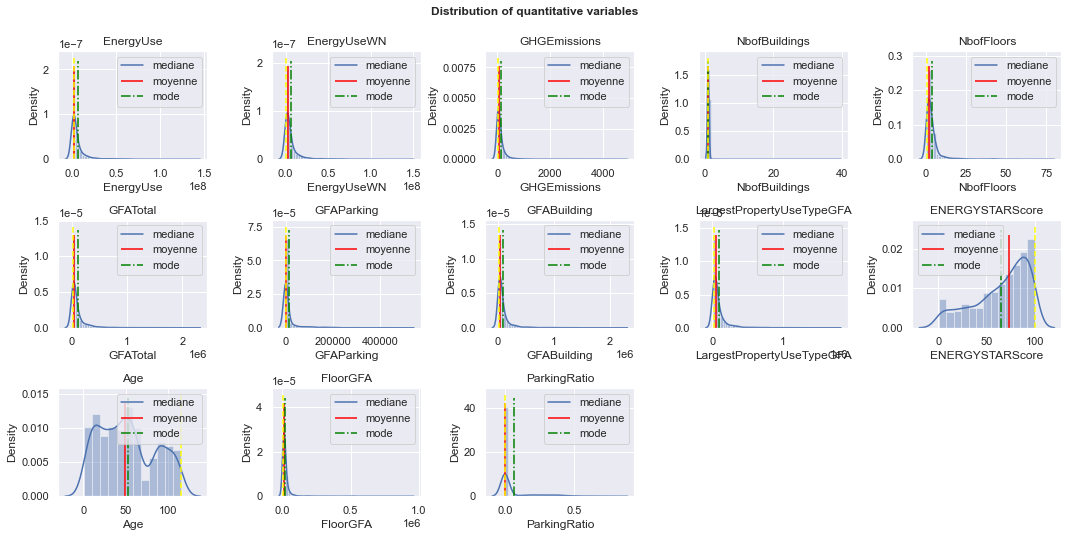

In [132]:
# Analysis of orders of magnitude for each of these variables
fig = plt.figure(figsize=(15,8))

for i, col in enumerate(COL_QUANT,1):
    ax = fig.add_subplot(3,5,i)
    #ax.hist(data[col],  bins=50)
    sns.distplot(data[col])
    #plt.xlabel(col)
    ax.set_title(col)
    ax.vlines(data[col].median(), *ax.get_ylim(), color='red', ls='-', lw=1.5)
    ax.vlines(data[col].mean(), *ax.get_ylim(),  color='green', ls='-.', lw=1.5)
    ax.vlines(data[col].mode()[0], *ax.get_ylim(), color='yellow', ls='--', lw=1.5)
    ax.legend(['mediane','moyenne','mode'])

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of quantitative variables', fontsize=12,
             fontweight='bold')

plt.show()

In [133]:
# Listing qualitative variables
COL_QUAL = data.select_dtypes(include = ['object']).columns.tolist()
COL_QUAL

['PropertyType', 'Neighborhood', 'LargestPropertyUseType']

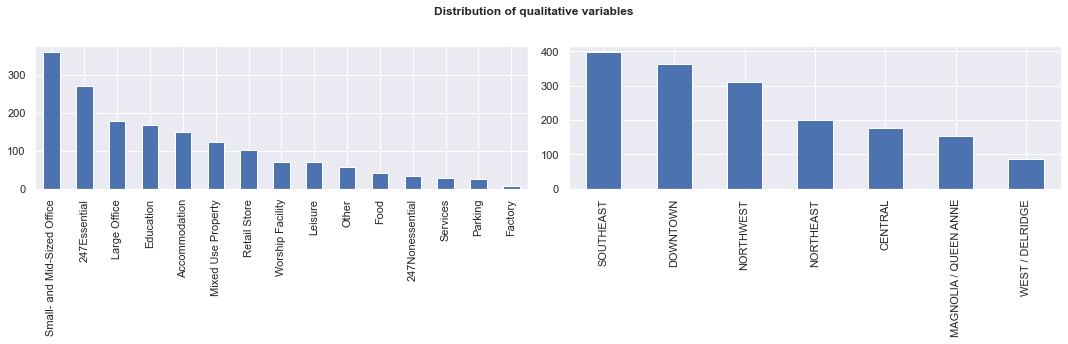

In [134]:
# Analysing orders of magnitude for each of these variables with few modalities
fig = plt.figure(figsize=(15,12))

for i, col in enumerate(['PropertyType', 'Neighborhood'],1):
    ax = fig.add_subplot(3,2,i)
    data[col].value_counts().plot(kind='bar')
    
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of qualitative variables', fontsize=12,
             fontweight='bold')

plt.show()

In [135]:
# Analysing file characteristics after feature engineering
analyse_data(data)

Dataset shape :  (1684, 37)
% NaNs :  0.008522180137382037


# <a name="C12">Correlation between variables</a>

In [136]:
# Displaying columns
data.columns

Index(['EnergyUse', 'EnergyUseWN', 'GHGEmissions', 'PropertyType',
       'CouncilDistrictCode', 'Neighborhood', 'NbofBuildings', 'NbofFloors',
       'GFATotal', 'GFAParking', 'GFABuilding', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SteamUse', 'ElecUse',
       'GasUse', 'OtherFuelUse', 'DefaultData', 'ComplianceStatus', 'Age',
       'FloorGFA', 'ParkingRatio', '247Essential', '247Nonessential',
       'Accommodation', 'Education', 'Food', 'Large Office', 'Leisure',
       'Mixed Use Property', 'Other', 'Parking', 'Retail Store', 'Services',
       'Small- and Mid-Sized Office', 'Worship Facility'],
      dtype='object')

In [137]:
#Creating a reduced data without PRopertyType encoder
data_red = data[['EnergyUse', 'EnergyUseWN', 'GHGEmissions', 
       'PropertyType', 'CouncilDistrictCode', 'Neighborhood', 'NbofBuildings',
       'NbofFloors', 'GFATotal', 'GFAParking', 'GFABuilding',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SteamUse', 'ElecUse', 'GasUse', 'OtherFuelUse',
       'DefaultData', 'ComplianceStatus', 'Age', 'FloorGFA', 'ParkingRatio']]

### Heatmap

C:\Users\najwa\AppData\Local\Temp\ipykernel_11852\2935329697.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


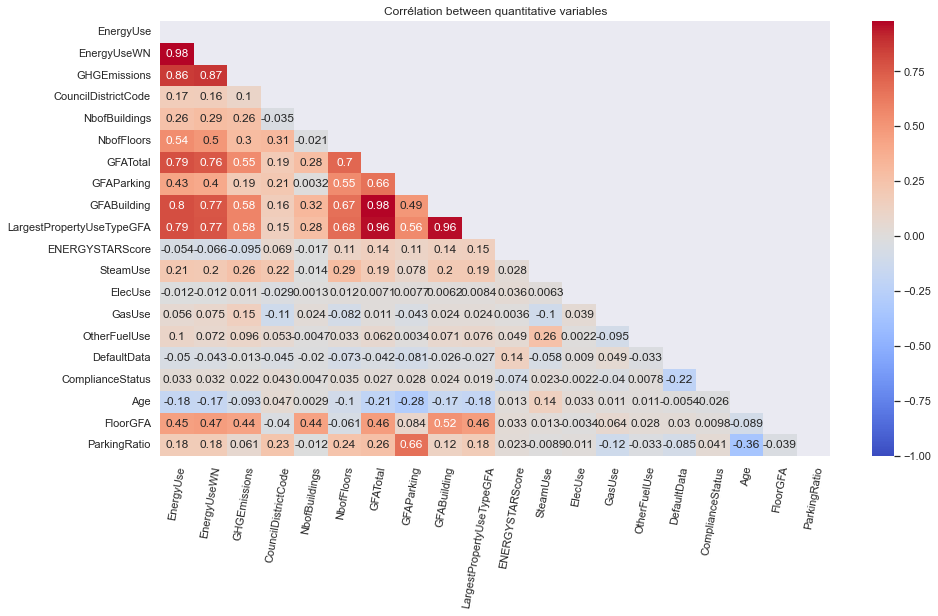

In [138]:
# Displaying heatmap correlation between quantitative variables
plt.figure(figsize=(15,8))
#sns.set(font_scale=1.5)
plt.title('Corrélation between quantitative variables', fontsize = 12)

corr = data_red.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 

ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm', annot = True)
plt.xticks(rotation=80)
plt.show()
sns.set(font_scale=1)

### Pairplot

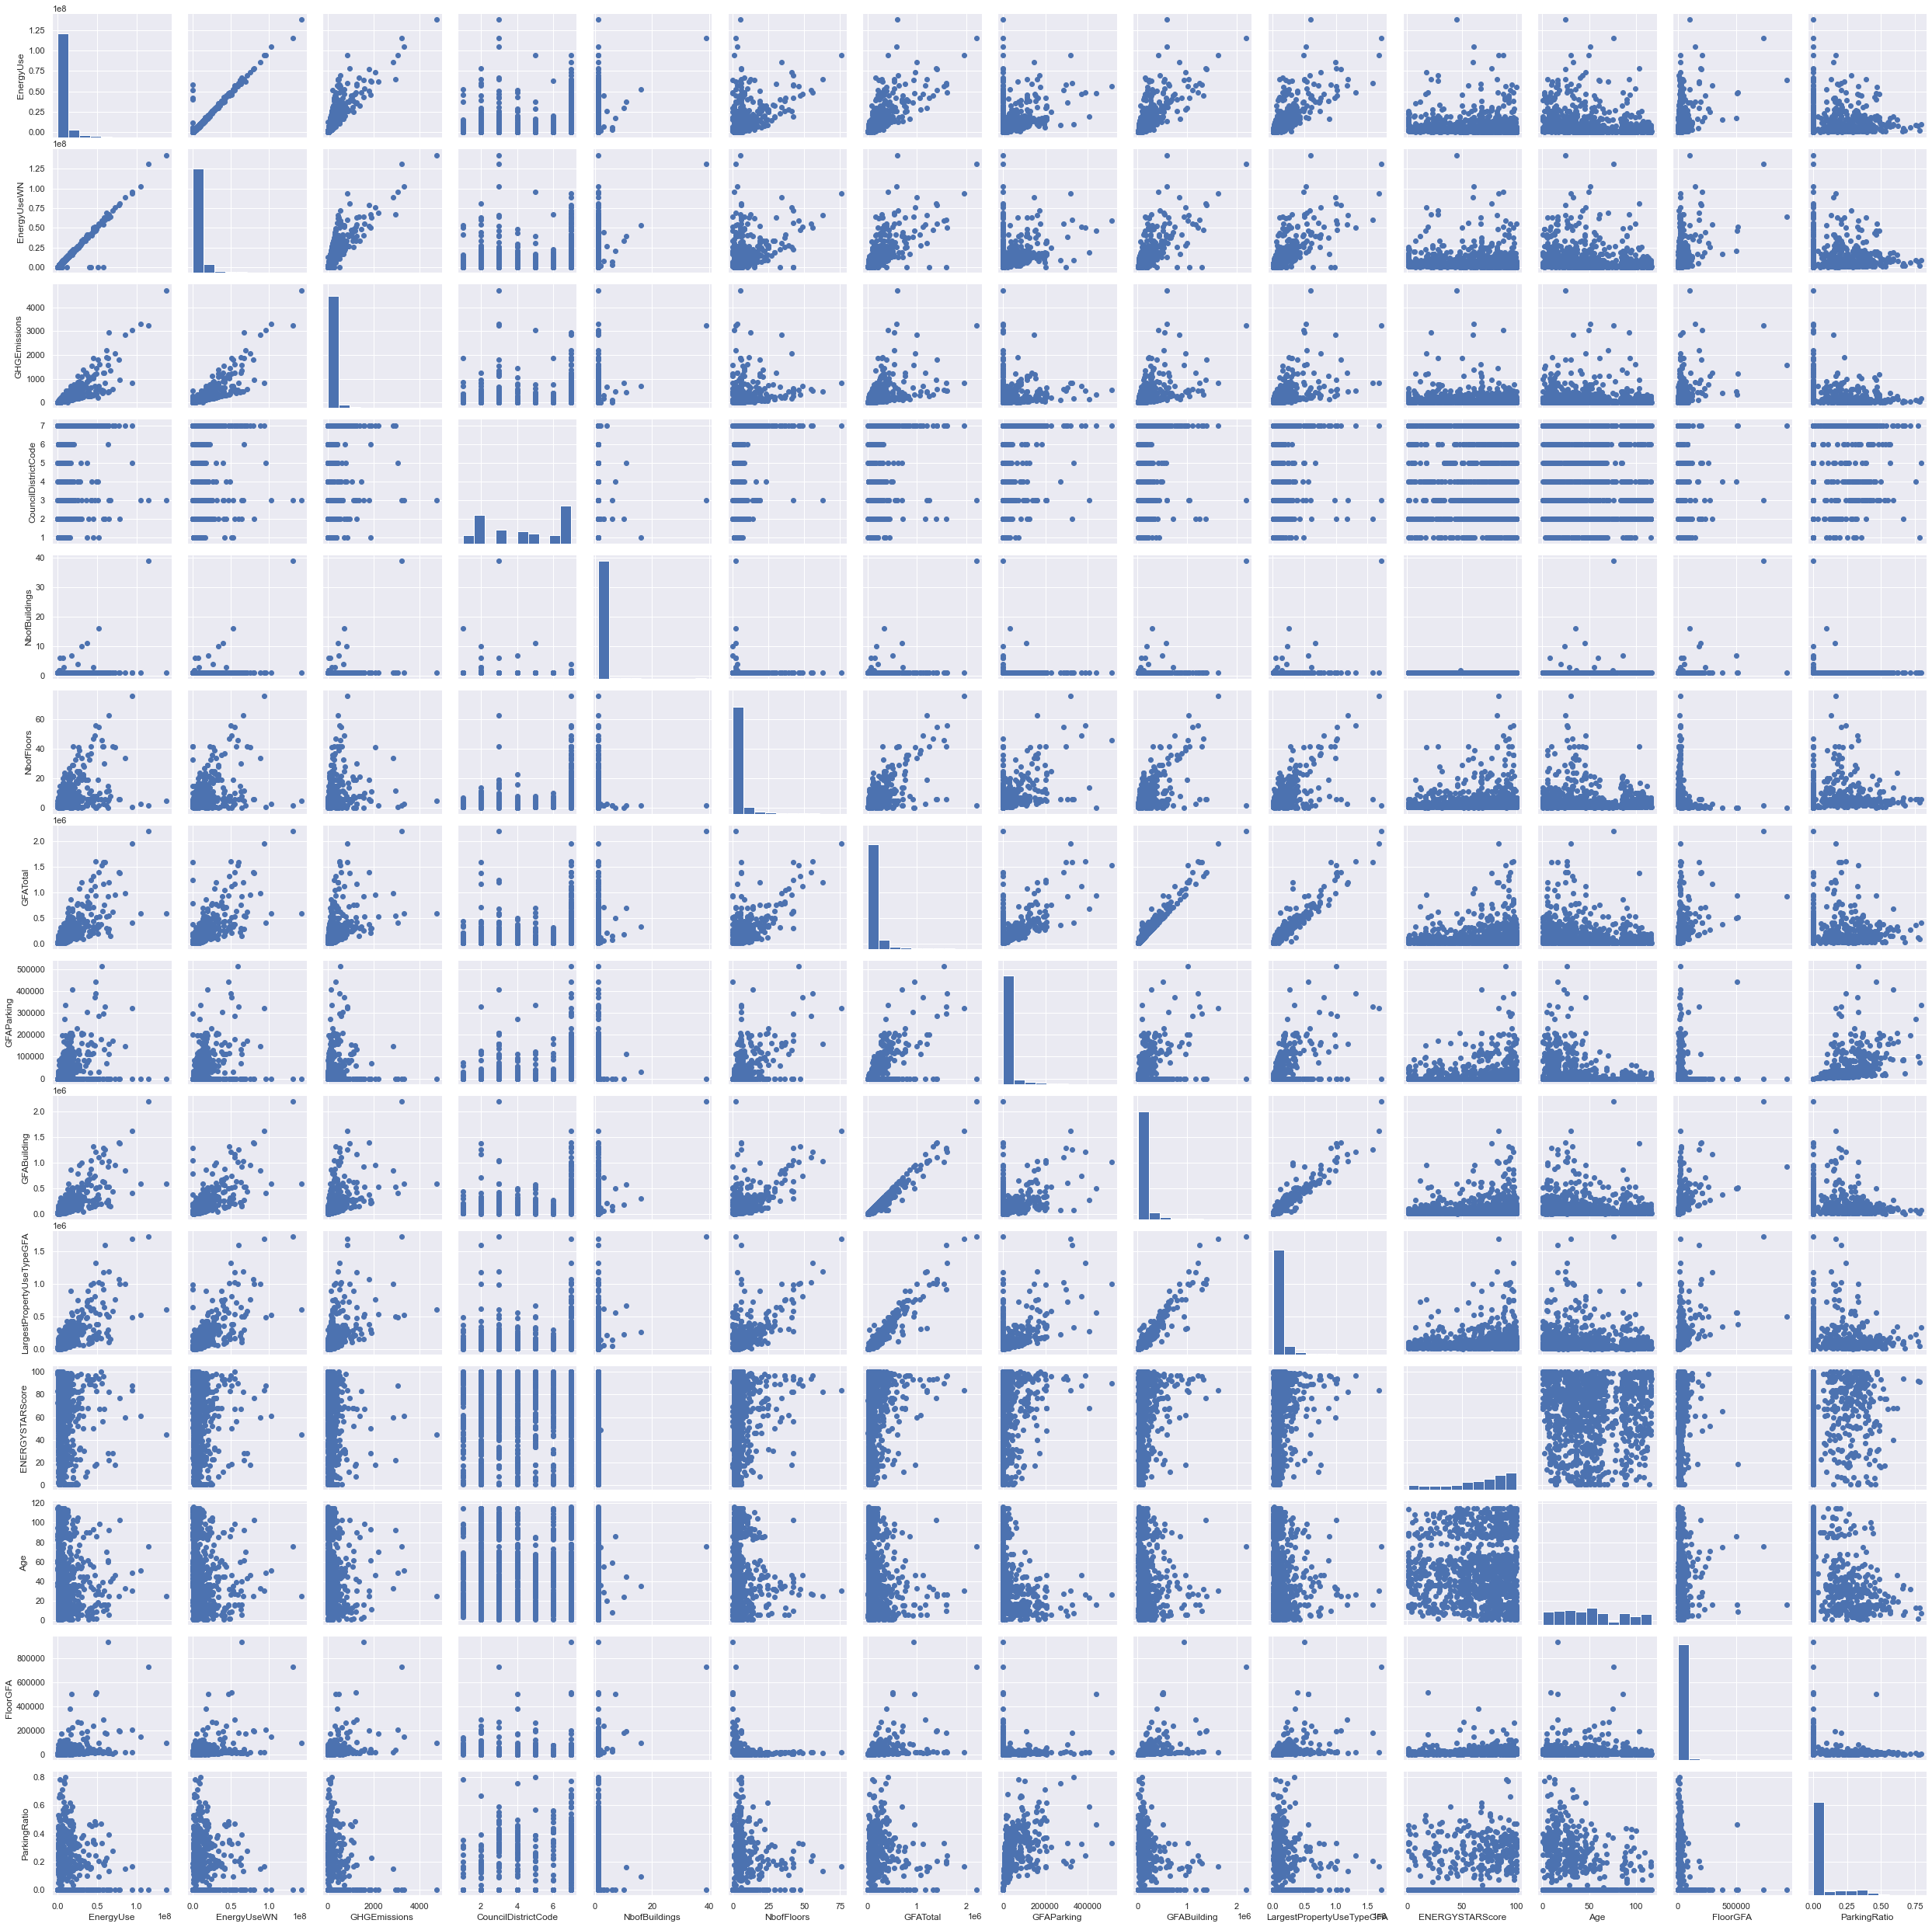

In [139]:
# Analysing pair
%matplotlib inline
COL_AED = ['EnergyUse', 'EnergyUseWN', 'GHGEmissions', 
       'PropertyType', 'CouncilDistrictCode', 'Neighborhood', 'NbofBuildings',
       'NbofFloors', 'GFATotal', 'GFAParking', 'GFABuilding',
       'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'Age', 'FloorGFA', 'ParkingRatio']
data_grid = data[COL_AED]
g = sns.PairGrid(data_grid)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);
plt.show()

### ANOVA

In [140]:
# Listing quantitative columns
COL_QUANT = data_red.select_dtypes(include = ['int64','float64']).columns.tolist()

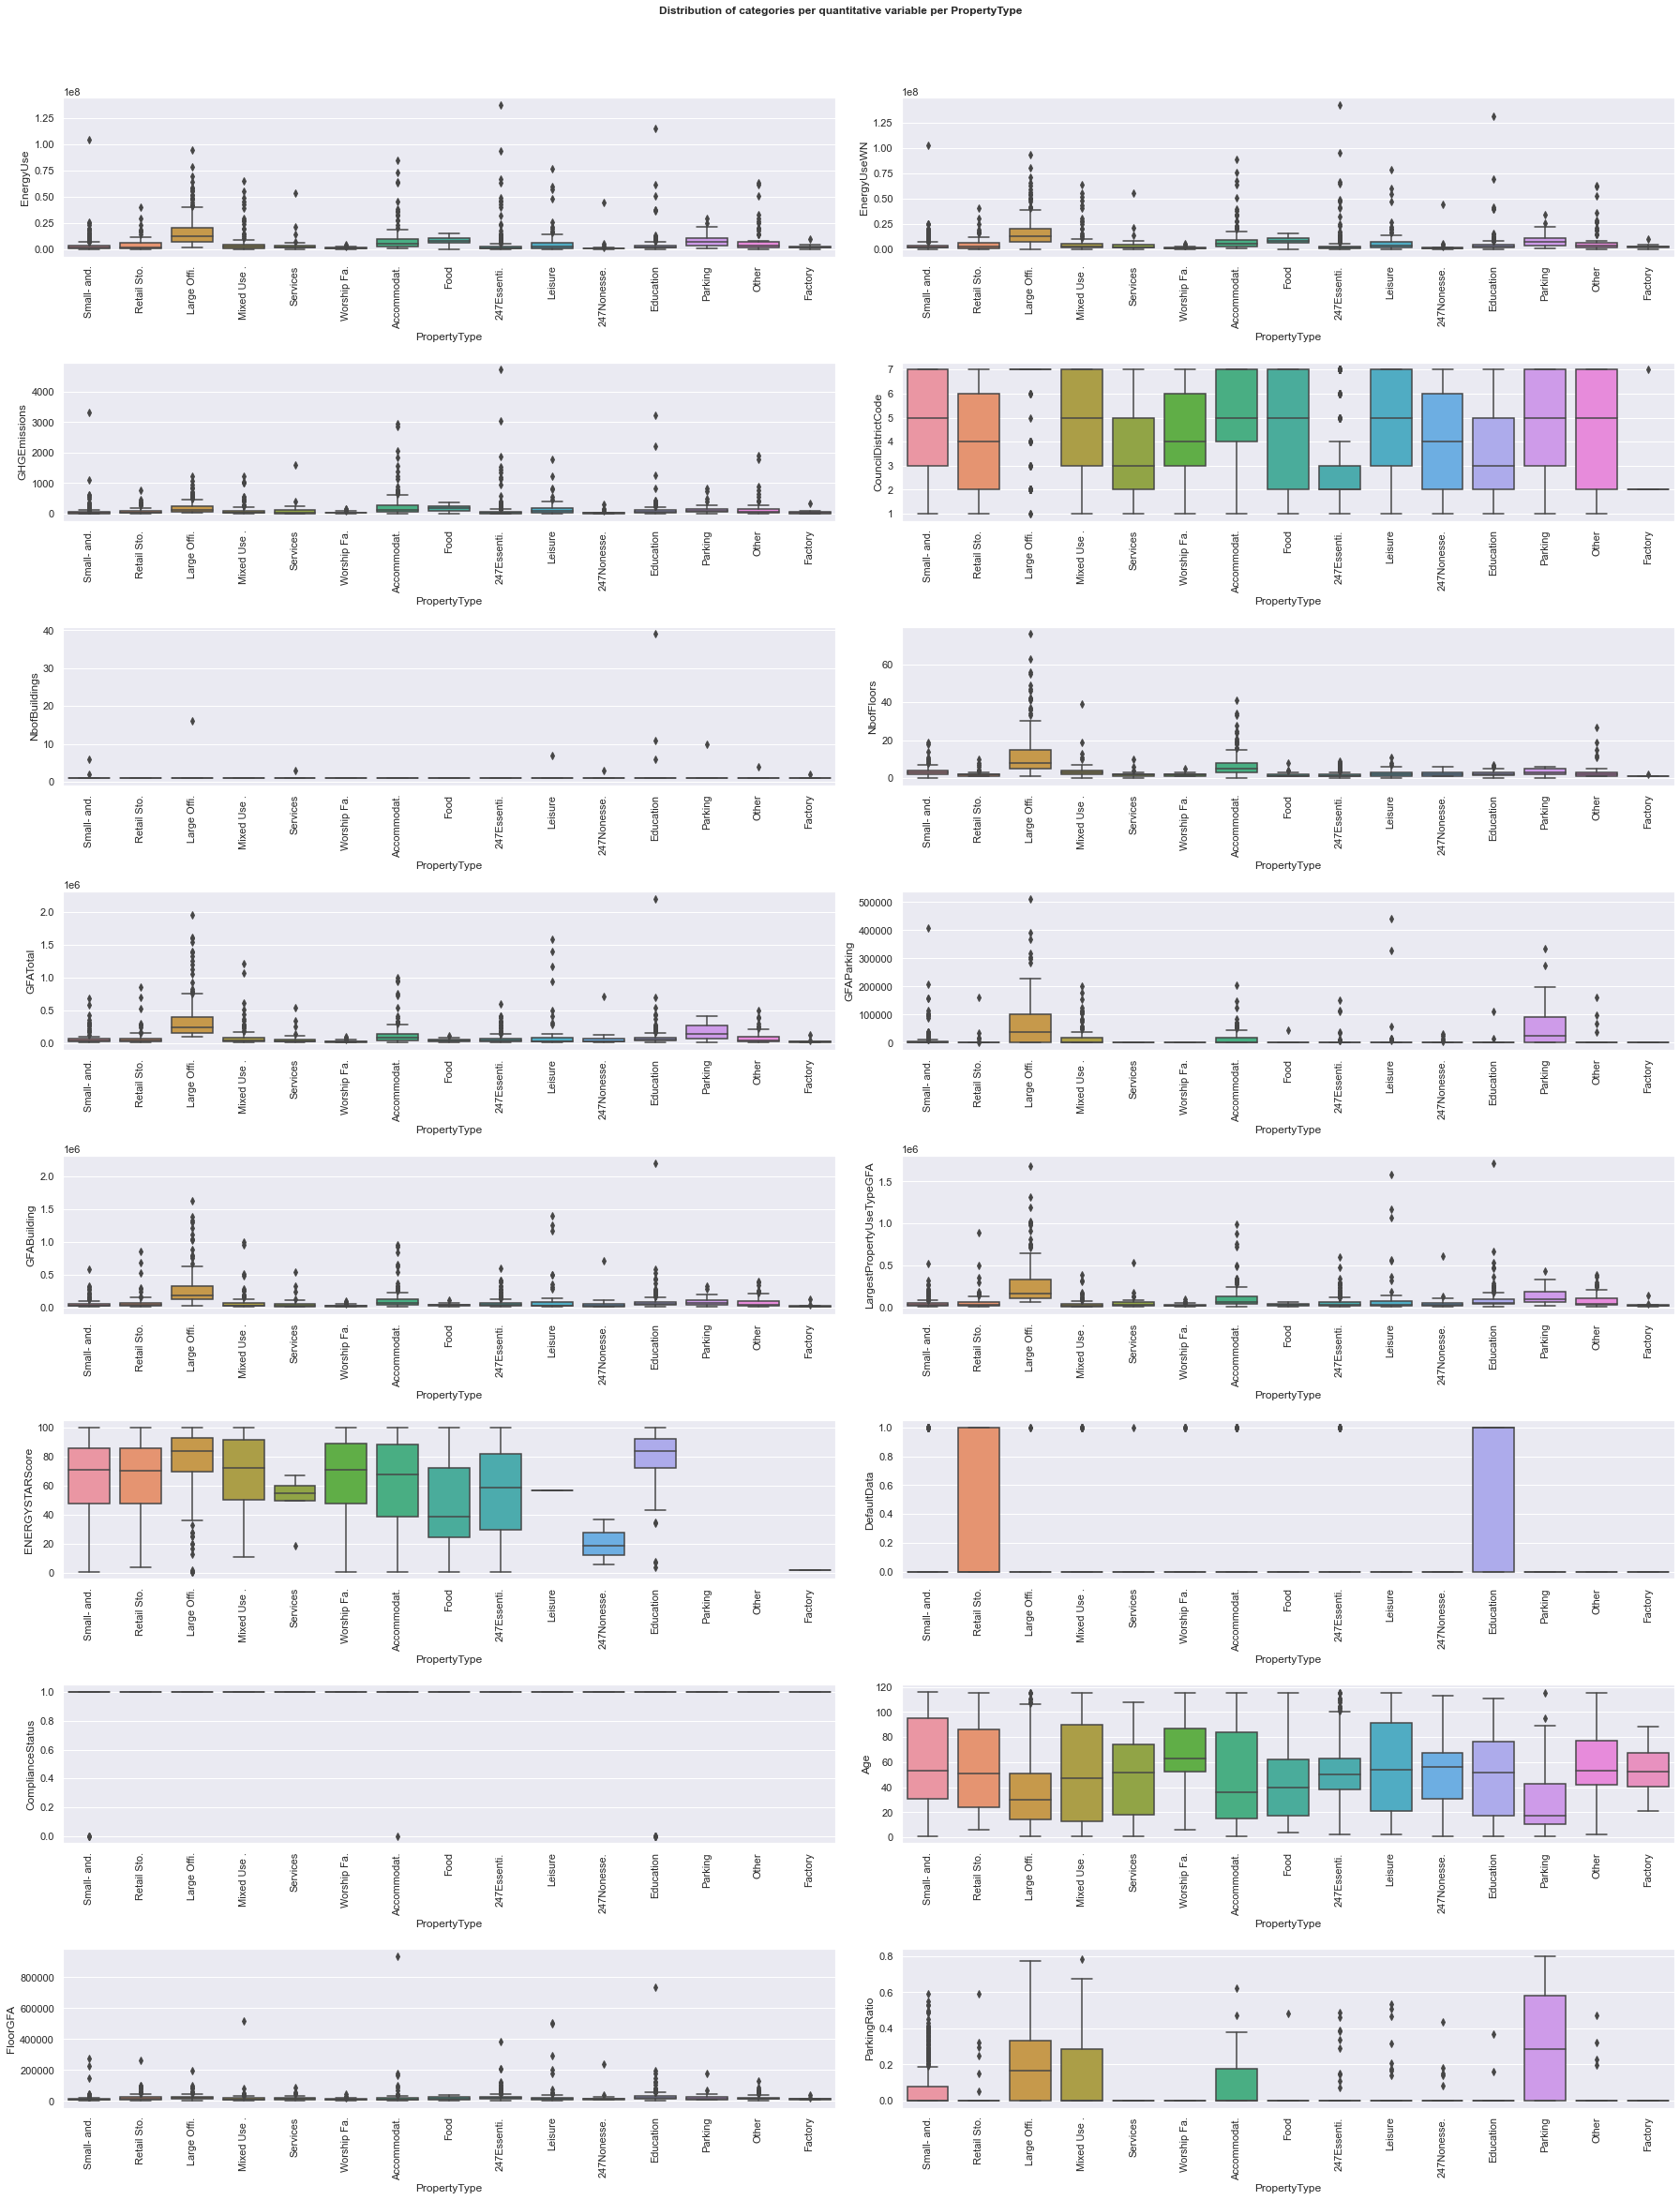

In [141]:
# Displaying boxplot for each quantitative variable per PropertyType (ANOVA)
fig = plt.figure(figsize=(25,35))

for i, c in enumerate(COL_QUANT,1):
    ax = fig.add_subplot(8,2,i)
    sns.boxplot(data=data_red, x='PropertyType', y=c, ax=ax)
    plt.xticks(rotation=90)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    short_labels = [s[0:10]+'.' if len(s)>10 else s for s in labels]
    ax.axes.set_xticklabels(short_labels)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
#plt.tight_layout()
plt.suptitle('Distribution of categories per quantitative variable per PropertyType', fontsize=12,
             fontweight='bold')
plt.show()

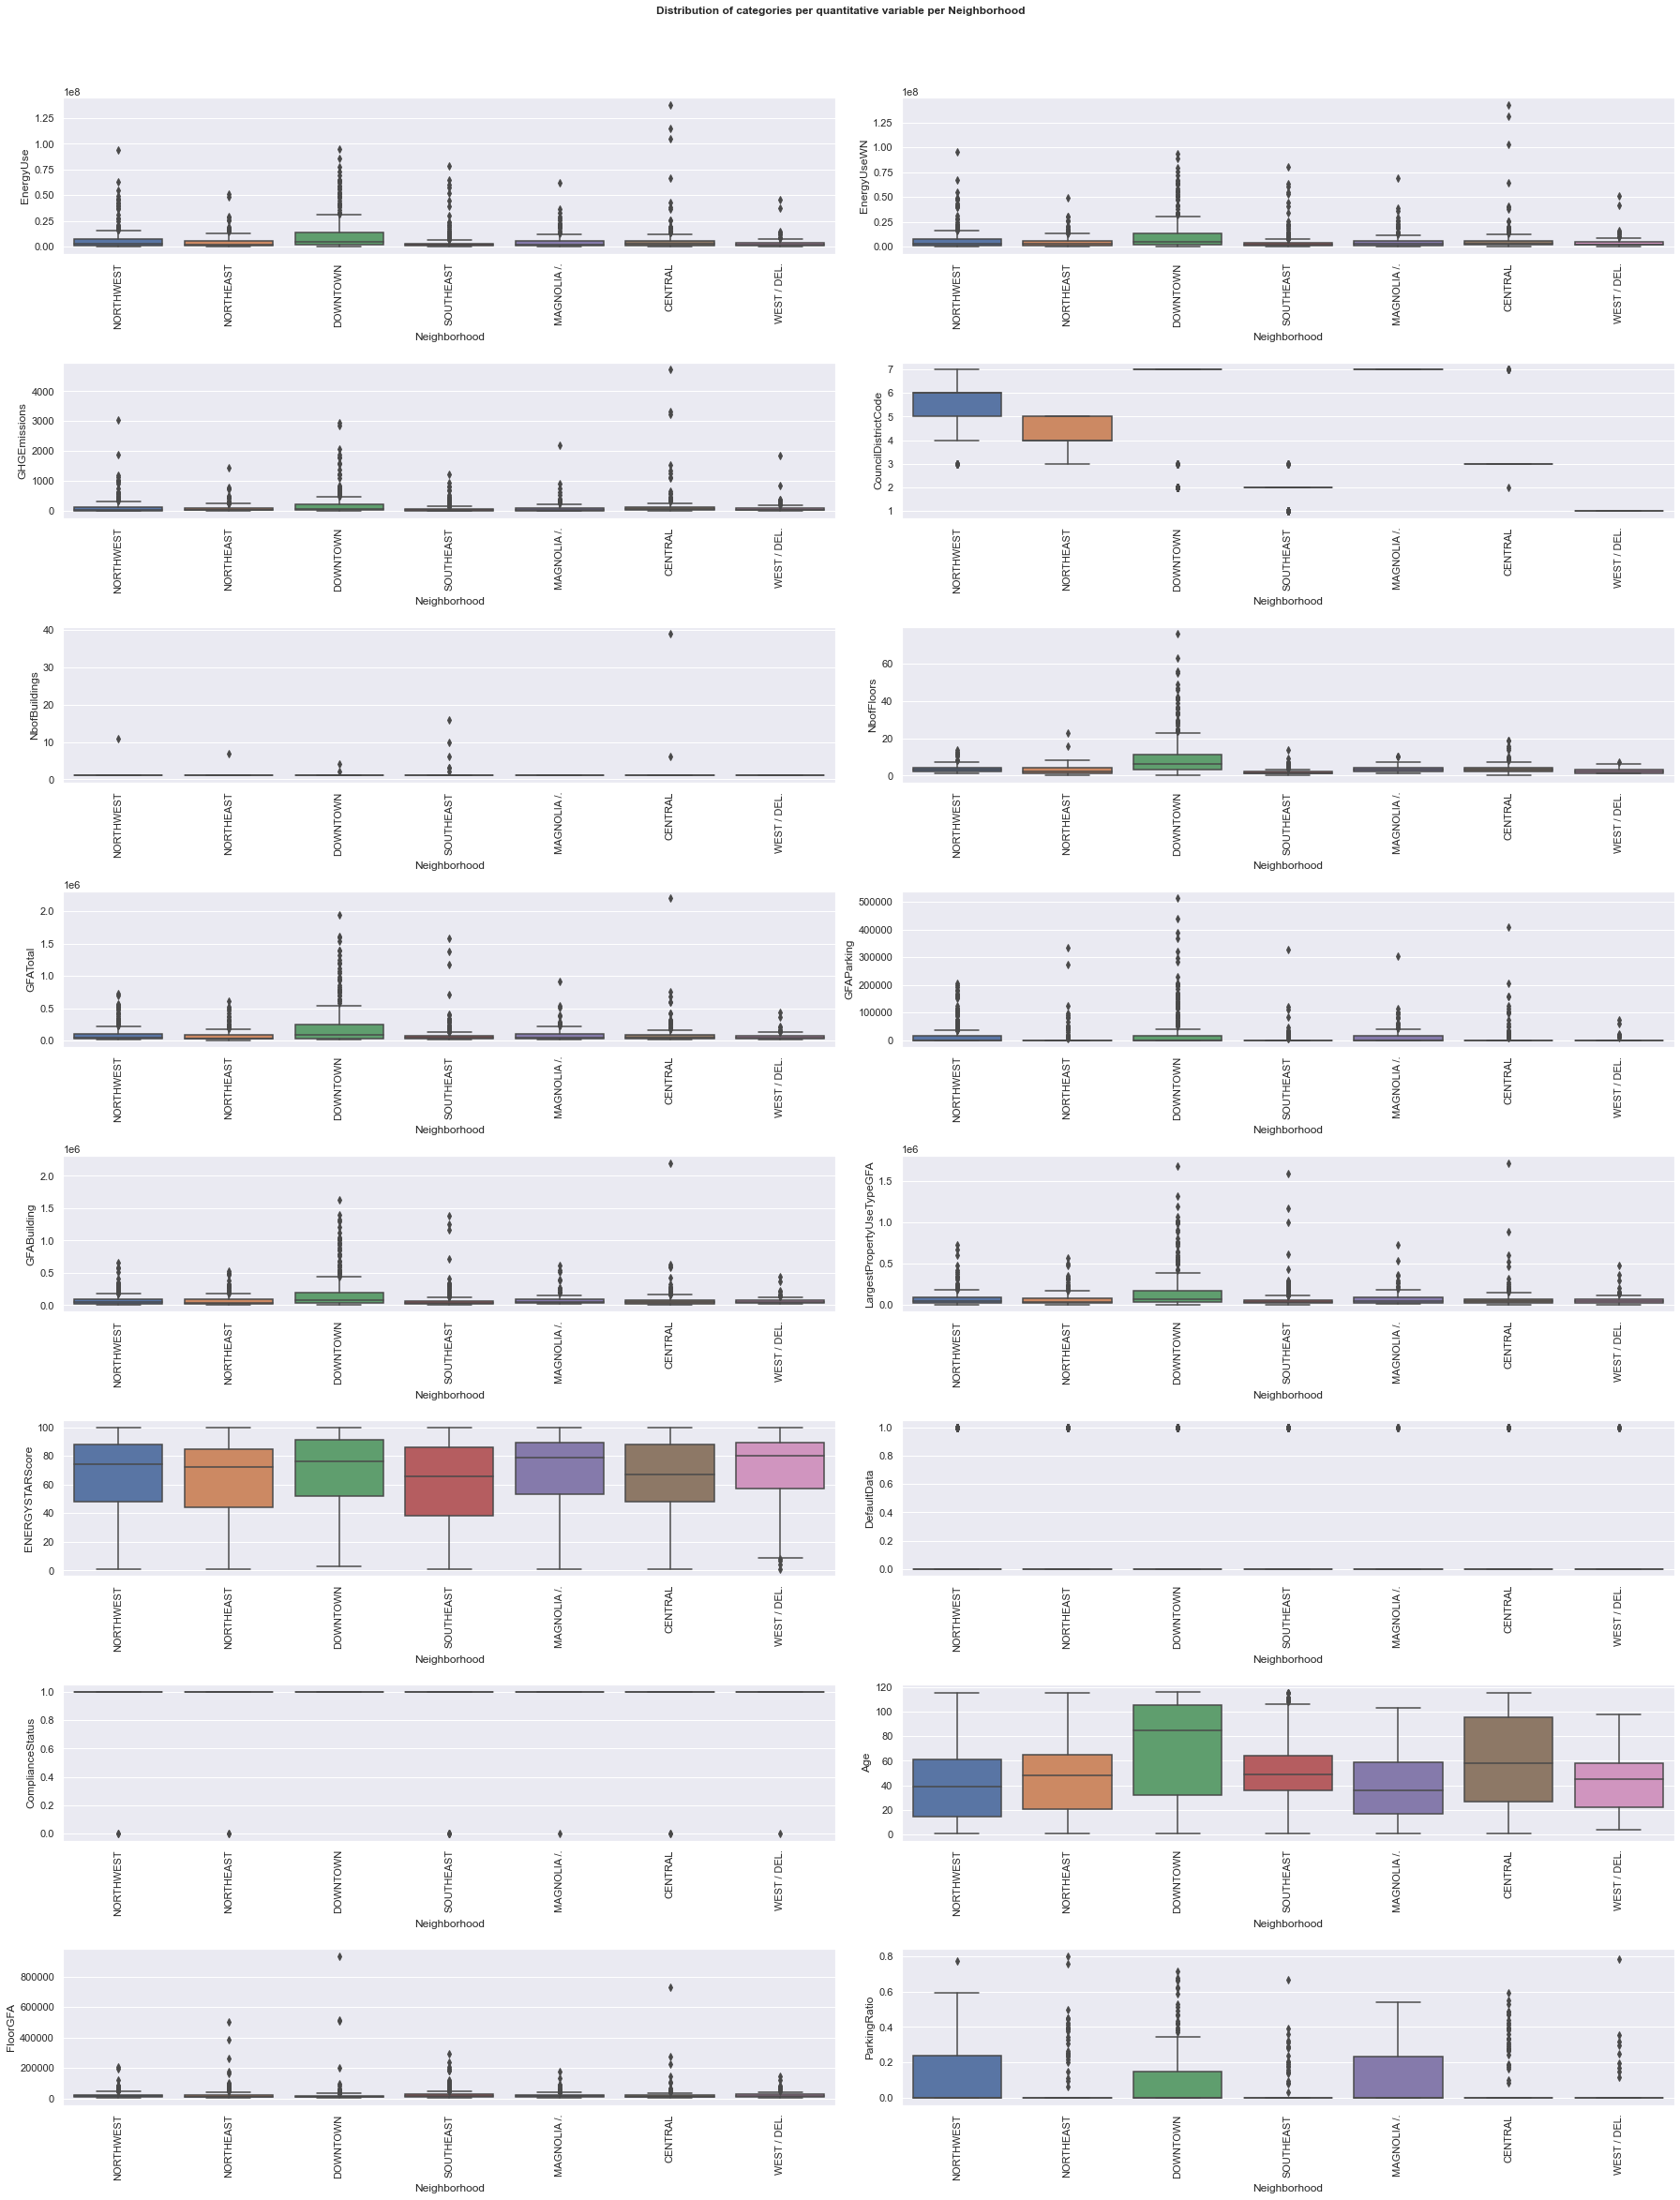

In [142]:
# Displaying boxplot for each quantitative variable per Neighborhood (ANOVA)
fig = plt.figure(figsize=(25,35))

for i, c in enumerate(COL_QUANT,1):
    ax = fig.add_subplot(8,2,i)
    sns.boxplot(data=data_red, x='Neighborhood', y=c, ax=ax)
    plt.xticks(rotation=90)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    short_labels = [s[0:10]+'.' if len(s)>10 else s for s in labels]
    ax.axes.set_xticklabels(short_labels)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
#plt.tight_layout()
plt.suptitle('Distribution of categories per quantitative variable per Neighborhood', fontsize=12,
             fontweight='bold')
plt.show()

### PCA

In [143]:
# Listing quantitative variables other than 0 and 1
COL_QUANT = ['EnergyUse',
 'EnergyUseWN',
 'GHGEmissions',
 'CouncilDistrictCode',
 'NbofBuildings',
 'NbofFloors',
 'GFATotal',
 'GFAParking',
 'GFABuilding',
 'LargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'Age',
 'FloorGFA',
 'ParkingRatio']

C:\Users\najwa\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


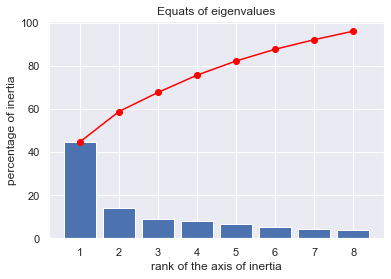

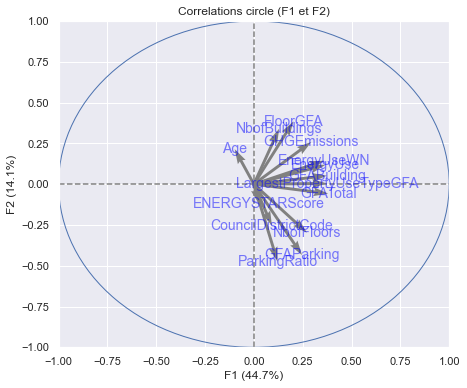

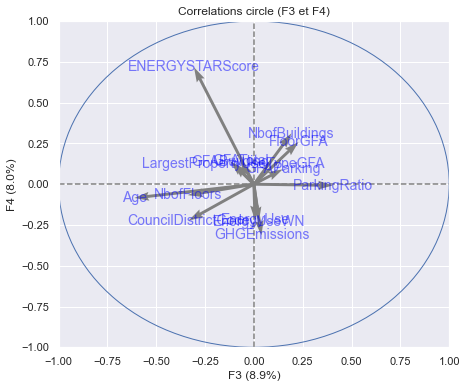

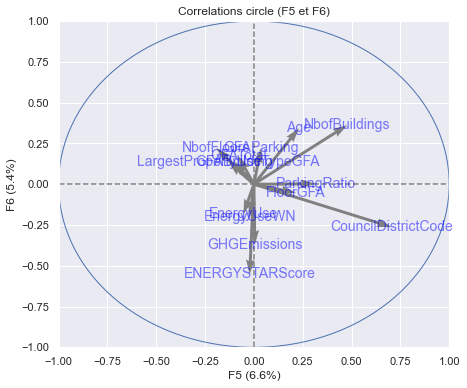

In [144]:
# Performing an ACP
# Chosing 8 components to compute
n_comp = 8

# Selecting columns to consider for PCA
acp_vars = COL_QUANT

data_pca = data_red[acp_vars]
data_pca = data_pca.fillna(data_pca.mean())

# Preparing data for PCA
X = data_pca.values
names = data_pca.index 
features = data_pca.columns

# Centering and reducing
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(data_pca[acp_vars])

# Computing main components 
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Decomposing eigenvalues
display_scree_plot(pca)

# Displaying circle of correlations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

plt.show()

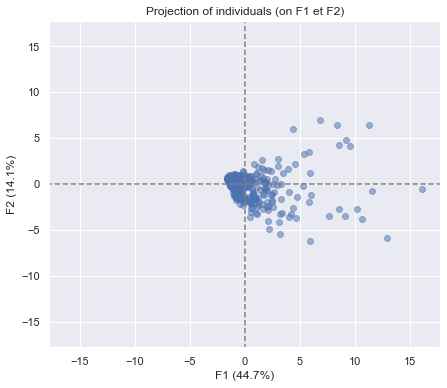

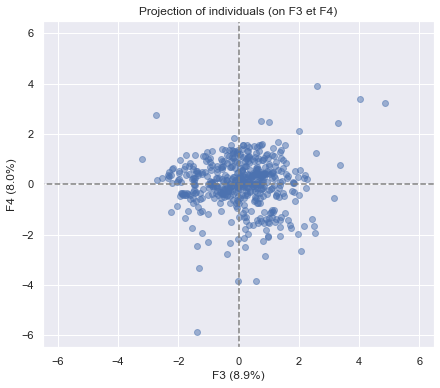

In [145]:
# Projecting individuals
X_projected = pca.transform(X_scaled)
X_sampled = X_projected[np.random.choice(X_projected.shape[0], 500, replace=False)]
display_factorial_planes(X_sampled, n_comp, pca, [(0,1),(2,3)], alpha=.5)
plt.show()

In [146]:
# Creating pca coefficients matrix
pcs = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=COL_QUANT).T
pcs

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
EnergyUse,0.366446,0.118593,0.005929,-0.220318,-0.053144,-0.181561,0.129537,-0.093500
EnergyUseWN,0.359931,0.144090,0.025953,-0.228260,-0.019797,-0.198352,0.157420,-0.112924
GHGEmissions,0.293762,0.259103,0.038749,-0.312844,0.005018,-0.370682,0.255819,-0.169457
CouncilDistrictCode,0.092590,-0.254473,-0.333391,-0.222056,0.704595,-0.262526,-0.414755,0.104061
NbofBuildings,0.129486,0.340219,0.192426,0.311441,0.477631,0.361926,-0.052804,-0.599373
NbofFloors,0.271298,-0.296867,-0.337659,-0.067087,-0.192569,0.221429,-0.172887,-0.244978
GFATotal,0.380352,-0.057464,-0.068094,0.141458,-0.080092,0.172545,-0.084707,0.123666
GFAParking,0.246547,-0.434567,0.147608,0.091220,0.036844,0.220355,0.280434,0.165110
GFABuilding,0.373488,0.052251,-0.119314,0.139035,-0.102925,0.139750,-0.174905,0.098198
LargestPropertyUseTypeGFA,0.374134,0.004892,-0.103080,0.123870,-0.129356,0.135271,-0.108505,0.074291


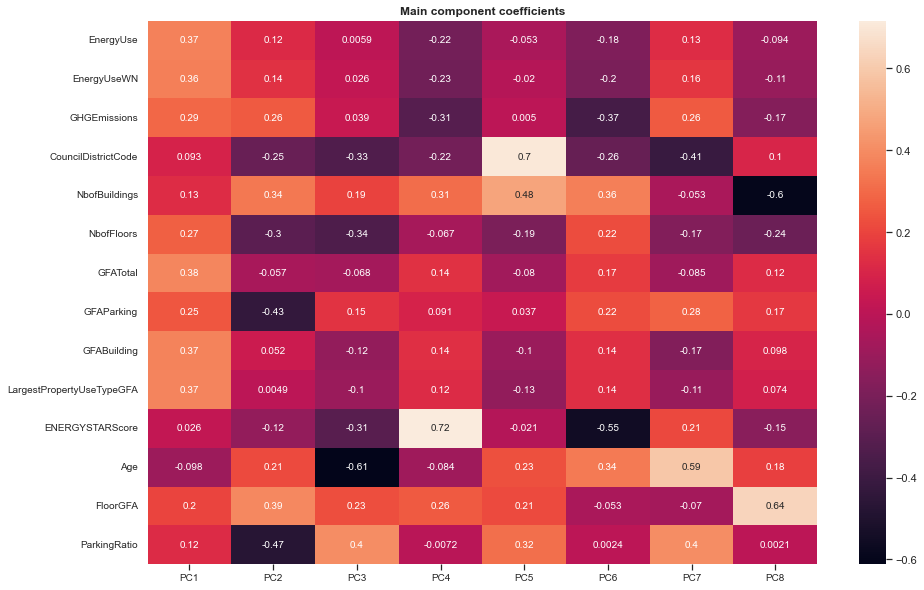

In [147]:
# Visualising this matrix
fig = plt.figure(figsize=(15,10))
sns.heatmap(pcs, annot=True,xticklabels= pcs.columns, yticklabels = pcs.index)
plt.tick_params(labelsize=10,top=False, bottom=True,
                labeltop=False, labelbottom=True)
plt.title("Main component coefficients", fontweight='bold', fontsize=12)
plt.show()

# <a name="C13">Selection of variables</a>

In [148]:
# Displaying columns
data.columns

Index(['EnergyUse', 'EnergyUseWN', 'GHGEmissions', 'PropertyType',
       'CouncilDistrictCode', 'Neighborhood', 'NbofBuildings', 'NbofFloors',
       'GFATotal', 'GFAParking', 'GFABuilding', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SteamUse', 'ElecUse',
       'GasUse', 'OtherFuelUse', 'DefaultData', 'ComplianceStatus', 'Age',
       'FloorGFA', 'ParkingRatio', '247Essential', '247Nonessential',
       'Accommodation', 'Education', 'Food', 'Large Office', 'Leisure',
       'Mixed Use Property', 'Other', 'Parking', 'Retail Store', 'Services',
       'Small- and Mid-Sized Office', 'Worship Facility'],
      dtype='object')

In [149]:
# Removing columns that are no longer useful or too correlated with others or very little correlated with targets
data = data.drop(['PropertyType','Neighborhood','LargestPropertyUseType','LargestPropertyUseTypeGFA','ElecUse','OtherFuelUse', 'DefaultData', 'ComplianceStatus','GFATotal','LargestPropertyUseType'],axis='columns')

In [150]:
# Dispalying file characteristics
analyse_data(data)

Dataset shape :  (1684, 28)
% NaNs :  0.011261452324397693


In [151]:
# Displaying missing values
data.isnull().sum()

EnergyUse                        0
EnergyUseWN                      0
GHGEmissions                     0
CouncilDistrictCode              0
NbofBuildings                    0
NbofFloors                       0
GFAParking                       0
GFABuilding                      0
ENERGYSTARScore                531
SteamUse                         0
GasUse                           0
Age                              0
FloorGFA                         0
ParkingRatio                     0
247Essential                     0
247Nonessential                  0
Accommodation                    0
Education                        0
Food                             0
Large Office                     0
Leisure                          0
Mixed Use Property               0
Other                            0
Parking                          0
Retail Store                     0
Services                         0
Small- and Mid-Sized Office      0
Worship Facility                 0
dtype: int64

In [152]:
# Copying file after final step of cleaning
data.to_csv('building-energy-benchmarking-nettoye.csv', index=False)

The end of notebook